# 手撸YOLO v1



## 1. 数据集加载与处理

### 1.1 下载数据集

In [ ]:
!bash scripts/download_voc.sh ./data/voc

数据集的划分如下:
- 训练集: VOC 2007 训练集 + VOC 2007 验证集 + VOC 2012 训练集 + VOC 2012 验证集
- 测试集: VOC 2007 测试集

In [ ]:
!bash scripts/organize_voc.sh ./data/voc

简化 .xml 格式的目标标注文件，仅保留标签和边界框坐标。

对于每个图像中的边界框，会创建一个相同名称的 .csv 文件。

CSV 文件的第一行是表头，之后的行格式为 `<object>,<xmin>,<ymin>,<xmax>,<ymax>`。

旧的 .xml 标注文件将被删除。

In [ ]:
!python scripts/simplify_voc_targets.py ./data/voc

如果需要小数据集进行训练（可选）
- --source_voc表示完整的voc原始数据的路径
- --target_voc表示筛选过后的小数据集存储路径
- --classes表示需要筛选的标签使用英文逗号隔开，例如： car,person,bus

In [ ]:
!python scripts/toy_voc.py --source_voc ./data/voc/VOC_Detection --target_voc ./data/voc/small_voc --classes car,person,bus

### 1.2 编写自定义数据集类

In [10]:
import torch
from torch.utils.data import Dataset
import os
import PIL.Image as Image
import csv
from typing import Callable, Optional, Tuple, Union, List


class VOC_Detection(Dataset):
    """
    自定义 PASCAL VOC 目标检测数据集的 Dataset 类。
    
    - 数据集包含 20 类目标，每个类别分配一个索引编号（从 0 开始）。
    - 同时，每个类别也分配了一个颜色（用于可视化）。
    """
    C = 20  # 类别数量

    # 20 个类别名称
    index2label = ["person",
                   "bird", "cat", "cow", "dog", "horse", "sheep",
                   "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
                   "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"]
    
    # 生成类别名称到索引的映射表
    label2index = {label: index for index, label in enumerate(index2label)}
    
    # 每个类别对应的颜色（用于可视化）
    label_clrs = ["#ff0000", "#2e8b57", "#808000", "#800000", "#000080", "#2f4f4f", "#ffa500",
                  "#00ff00", "#ba55d3", "#00fa9a", "#00ffff", "#0000ff", "#f08080", "#ff00ff",
                  "#1e90ff", "#ffff54", "#dda0dd", "#ff1493", "#87cefa", "#ffe4c4"]

    def __init__(self, root_dir: str, split: str = 'train',
                 transforms: Optional[Callable] = None) -> None:
        """
        初始化 PASCAL VOC 目标检测数据集。

        :param root_dir: 数据集的根目录（包含 `train/` 和 `test/` 子目录）。
        :param split: 指定数据集的划分（'train' 或 'test'）。
        :param transforms: 传入的数据增强方法（可选），用于处理图像和标签。
        """
        assert split in ['train', 'test'], "split 只能是 'train' 或 'test'"
        split_dir = os.path.join(root_dir, split)

        self.img_dir = os.path.join(split_dir, "images")  # 图像文件夹
        self.annot_dir = os.path.join(split_dir, "targets")  # 目标标签文件夹
        
        # 获取所有文件名（去掉后缀 .csv）
        self.pseudonyms = [filename[:-4] for filename in os.listdir(self.annot_dir)]
        self.transforms = transforms  # 数据增强方法

    def __len__(self) -> int:
        """
        返回数据集的总样本数。
        """
        return len(self.pseudonyms)

    def __getitem__(self, idx: int) -> Tuple[Union[torch.Tensor, Image.Image], torch.Tensor]:
        """
        根据索引获取对应的图像和目标标签。

        :param idx: 样本索引（范围：[0, 数据集长度)）。
        :return: 返回一个 (image, target) 对。
        """
        pid = self.pseudonyms[idx]  # 获取样本 ID
        img_path = os.path.join(self.img_dir, f'{pid}.jpg')  # 图像路径
        annot_path = os.path.join(self.annot_dir, f'{pid}.csv')  # 标签文件路径

        # 读取图像
        img = Image.open(img_path)
        
        # 读取目标框信息
        target = []
        with open(annot_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader)  # 跳过 CSV 头部
            for row in csv_reader:
                # row[0] 是目标类别名称，row[1] - row[4] 是边界框坐标
                target.append([self.label2index[row[0]]] + [int(row[i]) for i in range(1, 5)])
        
        target = torch.Tensor(target)  # 转换为 PyTorch 张量

        # 如果定义了数据增强，应用到 (image, target)
        if self.transforms is not None:
            img, target = self.transforms((img, target))
        
        return img, target

### 1.3 数据增强

我们将下面数据增强的相关代码放在`transforms.py`中，后续通过`import transforms`使用

In [12]:
import torch as th
from torch.nn.functional import one_hot
from torchvision import transforms
import torchvision.transforms.functional as fT
import PIL.Image as Image
from typing import Tuple, Optional, List


class Resize:
    """
    可调用的图像缩放类，在调用时会调整图像大小并相应缩放边界框坐标。
    """

    def __init__(self, output_size: int) -> None:
        """
        初始化变换后的图像维度d。图像变换后将具有(d x d)形状。

        :param output_size: 变换后的图像维度。
        """
        self.d = output_size

    def __call__(self, sample: Tuple[Image.Image, th.Tensor]
                 ) -> Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]:
        """
        将图像调整为(d x d)形状并转换边界框坐标。
        在包含N个对象的图像中，目标张量形状为(N x 5)，每个对象的格式为：
        <分类ID>, <x_min>, <y_min>, <x_max>, <y_max>。对于(h x w)图像，坐标更新方式：

        | x' = x * d / w
        | y' = y * d / h

        :param sample: 包含图像及其对应目标的元组
        :return: 调整后的图像、包含所有有效像素的掩码区域([0,d]范围)、缩放后的坐标
        """
        img, target = sample
        w, h = img.size

        img = fT.resize(img, (self.d, self.d))
        target[:, [1, 3]] *= self.d / w
        target[:, [2, 4]] *= self.d / h

        mask = [(0, self.d), (0, self.d)]
        return img, mask, target


class RandomScaleTranslate:
    """
    可调用随机缩放平移类，用于调整图像大小并转换边界框坐标。为增强数据集，对每张图像随机选择以下操作：
    - 直接缩放
    - 缩小后缩放
    - 放大后缩放

    当缩小图像时，会用零填充。为避免扭曲这些零值（如颜色抖动、归一化），返回掩码标识有效区域。
    """
    def __init__(self,
                 output_size: int,
                 jitter: float,
                 resize_p: float,
                 zoom_out_p: float,
                 zoom_in_p: float) -> None:
        """
        初始化变换后的图像维度d，存储抖动因子用于随机缩放平移，使用概率参数选择操作。

        :param output_size: 变换后的图像维度
        :param jitter: 控制随机缩放和平移的因子
        :param resize_p: 直接缩放操作的概率
        :param zoom_out_p: 缩小后缩放操作的概率
        :param zoom_in_p: 放大后缩放操作的概率
        """
        self.d = output_size
        self.jitter = jitter
        self.t_probs = th.cumsum(th.Tensor([resize_p, zoom_out_p, zoom_in_p]), dim=0)

    def __call__(self, sample: Tuple[Image.Image, th.Tensor]
                 ) -> Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]:
        """
        从均匀分布中采样决定执行哪个操作，调整图像尺寸并转换边界框坐标，返回掩码标识有效区域。
        对于过小的边界框会进行移除。

        :param sample: 包含图像及其目标的元组
        :return: 变换后的图像、掩码区域及更新后的目标
        """

        transform_prob = th.rand(1)
        if transform_prob < self.t_probs[0]:                    # 直接缩放
            img, mask, target = self._resize(sample)
        elif transform_prob < self.t_probs[1]:                  # 缩小后缩放
            img, mask, target = self._zoom_out(sample)
        else:                                                   # 放大后缩放
            img, mask, target = self._zoom_in(sample)

        # 移除过小的边界框
        bboxes_w = target[:, 3] - target[:, 1]
        bboxes_h = target[:, 4] - target[:, 2]
        threshold = 0.001 * self.d
        valid_bboxes = th.logical_not(th.logical_or(bboxes_w < threshold, bboxes_h < threshold))
        target = target[valid_bboxes]
        return img, mask, target

    def _resize(self, sample: Tuple[Image.Image, th.Tensor]
                ) -> Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]:
        """
        执行与Resize类相同的直接缩放逻辑。

        :param sample: 包含图像及其目标的元组
        :return: 缩放后的图像、全尺寸掩码及更新后的目标
        """
        img, target = sample
        w, h = img.size

        img = fT.resize(img, (self.d, self.d))
        target[:, [1, 3]] *= self.d / w
        target[:, [2, 4]] *= self.d / h

        mask = [(0, self.d), (0, self.d)]
        return img, mask, target

    def _zoom_out(self, sample: Tuple[Image.Image, th.Tensor]
                  ) -> Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]:
        """
        通过随机采样新宽高比实现缩小操作：
        1. 计算新宽高比new_ar = rand_w / rand_h
        2. 根据宽高比确定新尺寸(d, k)或(k, d)
        3. 随机平移并填充图像
        4. 转换坐标并生成掩码标识有效区域

        :param sample: 包含图像及其目标的元组
        :return: 缩小后的图像、掩码区域及更新后的目标
        """

        img, target = sample
        w, h = img.size

        dw = w * self.jitter
        dh = h * self.jitter
        rand_w = w + th.Tensor(1).uniform_(-dw, dw)
        rand_h = h + th.Tensor(1).uniform_(-dh, dh)
        new_ar = rand_w / rand_h

        if new_ar < 1:
            nh = self.d
            nw = int(nh * new_ar + 0.5)
        else:
            nw = self.d
            nh = int(nw / new_ar + 0.5)

        dx = th.randint(low=0, high=self.d - nw + 1, size=(1,)).item()
        dy = th.randint(low=0, high=self.d - nh + 1, size=(1,)).item()

        img = fT.resize(img, (nh, nw))
        target[:, [1, 3]] *= nw / w
        target[:, [2, 4]] *= nh / h

        img = fT.pad(img, padding=[dx, dy, self.d - nw - dx, self.d - nh - dy])
        target[:, [1, 3]] += dx
        target[:, [2, 4]] += dy

        mask = [(dx, dx + nw), (dy, dy + nh)]
        return img, mask, target

    def _zoom_in(self, sample: Tuple[Image.Image, th.Tensor]
                 ) -> Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]:
        """
        随机采样裁剪区域并放大：
        1. 在原图上随机裁剪子区域
        2. 将子区域缩放到目标尺寸
        3. 移除不可见的边界框，裁剪部分可见的框进行坐标修正

        :param sample: 包含图像及其目标的元组
        :return: 放大后的图像、全尺寸掩码及更新后的目标
        """
        img, target = sample
        w, h = img.size

        nw = int(th.Tensor(1).uniform_((1 - self.jitter) * w, w) + 0.5)
        nh = int(th.Tensor(1).uniform_((1 - self.jitter) * h, h) + 0.5)
        dx = int(th.Tensor(1).uniform_(0, w - nw + 1) + 0.5)
        dy = int(th.Tensor(1).uniform_(0, h - nh + 1) + 0.5)

        img = fT.resized_crop(img, top=dy, left=dx, height=nh, width=nw, size=(self.d, self.d))

        target[:, [1, 3]] -= dx
        target[:, [2, 4]] -= dy
        target[:, [1, 3]] *= self.d / nw
        target[:, [2, 4]] *= self.d / nh

        # 移除完全不可见的边界框
        target = target[th.logical_not(th.logical_or(th.logical_or(target[:, 3] < 0, target[:, 1] > self.d),
                                                     th.logical_or(target[:, 4] < 0, target[:, 2] > self.d)))]

        # 修正部分可见框的坐标
        target[:, [1, 2]] = target[:, [1, 2]].clamp(min=0)
        target[:, [3, 4]] = target[:, [3, 4]].clamp(max=self.d)

        mask = [(0, self.d), (0, self.d)]
        return img, mask, target


class RandomColorJitter:
    """
    可调用随机颜色抖动类，对输入图像进行颜色扭曲，目标值保持不变。
    """

    def __init__(self, hue: float, sat: float, exp: float):
        """
        初始化色调、饱和度和曝光参数。

        :param hue: 色调参数，从[-hue, hue]均匀采样
        :param sat: 饱和度参数，从[1/sat, sat]均匀采样
        :param exp: 曝光参数，从[1/exp, exp]均匀采样
        """
        self.hue = hue
        self.sat = sat
        self.exp = exp

    def __call__(self, sample: Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]
                 ) -> Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]:
        """
        在HSV空间调整颜色：
        - 色调：加减随机值并循环处理
        - 饱和度：乘以随机因子并截断
        - 曝光：乘以随机因子并截断

        :param sample: 包含图像、掩码及目标的元组
        :return: 颜色调整后的图像及未变化的目标
        """
        rand_hue = th.Tensor(1).uniform_(-self.hue, self.hue)
        rand_sat = th.Tensor(1).uniform_(1 / self.sat, self.sat)
        rand_exp = th.Tensor(1).uniform_(1 / self.exp, self.exp)

        rgb_img, mask, target = sample
        hsv_img = rgb_img.convert('HSV')
        hsv_tensor = fT.to_tensor(hsv_img)

        mask_x, mask_y = mask
        masked_hsv_tensor = hsv_tensor[:, mask_y[0]:mask_y[1], mask_x[0]:mask_x[1]]

        # 调整色调
        masked_hsv_tensor[0, :, :] += rand_hue
        masked_hsv_tensor[0, :, :] += (1. * (masked_hsv_tensor[0, :, :] < 0) - 1. * \
                                       (masked_hsv_tensor[0, :, :] > 1)) * th.ones_like(masked_hsv_tensor[0, :, :])
        # 调整饱和度
        masked_hsv_tensor[1, :, :] *= rand_sat
        masked_hsv_tensor[1, :, :] = masked_hsv_tensor[1, :, :].clamp(max=1.0)

        # 调整曝光
        masked_hsv_tensor[2, :, :] *= rand_exp
        masked_hsv_tensor[2, :, :] = masked_hsv_tensor[2, :, :].clamp(max=1.0)

        hsv_img = fT.to_pil_image(hsv_tensor, mode='HSV')
        rgb_img = hsv_img.convert('RGB')

        return rgb_img, mask, target


class RandomHorizontalFlip:
    """
    可调用随机水平翻转类，随机决定是否翻转图像，同时调整边界框坐标和掩码。
    """
    def __init__(self, p: float) -> None:
        """
        初始化翻转概率。

        :param p: 应用水平翻转的概率
        """
        self.p = p

    def __call__(self, sample: Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]
                 ) -> Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]:
        """
        按概率p翻转图像，调整x坐标并更新掩码。

        :param sample: 包含图像、掩码及目标的元组
        :return: 翻转后的图像或原始样本
        """
        apply_transform = th.rand(1) < self.p
        if not apply_transform:
            return sample

        img, mask, target = sample
        w = img.size[0]

        target[:, [1, 3]] = w - target[:, [3, 1]]
        img = fT.hflip(img)

        start_x, end_x = mask[0]
        mask[0] = (w - end_x, w - start_x)

        return img, mask, target


class ToYOLOTensor:
    """
    可调用YOLO张量转换类，将目标转换为YOLO格式，图像转为张量，可选归一化。
    """

    def __init__(self, S: int, C: int, normalize: Optional[List] = None) -> None:
        """
        初始化YOLO网格参数。

        :param S: 网格尺寸（S x S）
        :param C: 数据集类别数
        :param normalize: 各通道的均值和标准差
        """
        self.S = S
        self.C = C
        self.normalize = normalize

    def __call__(self, sample: Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]
                 ) -> Tuple[th.Tensor, th.Tensor]:
        """
        转换目标为(SxS)网格格式：
        - 每个单元格包含存在概率、one-hot类别、归一化中心坐标和尺寸

        :param sample: 包含图像、掩码及目标的元组
        :return: 图像张量和YOLO格式目标
        """
        img, mask, target = sample
        w, h = img.size

        cell_w = w / self.S
        cell_h = h / self.S

        center_x = (target[:, 1] + target[:, 3]) / 2
        center_y = (target[:, 2] + target[:, 4]) / 2
        bndbox_w = target[:, 3] - target[:, 1]
        bndbox_h = target[:, 4] - target[:, 2]

        label = target[:, 0].long()
        center_col = th.div(center_x, cell_w, rounding_mode="trunc").long()
        center_row = th.div(center_y, cell_h, rounding_mode="trunc").long()
        norm_center_x = (center_x % cell_w) / cell_w
        norm_center_y = (center_y % cell_h) / cell_h
        norm_bndbox_w = bndbox_w / w
        norm_bndbox_h = bndbox_h / h

        target = th.zeros((self.S, self.S, self.C + 5))
        target[center_row, center_col, :] = th.cat([th.ones((label.shape[0], 1)),
                                                    one_hot(label, self.C),
                                                    norm_center_x.unsqueeze(1),
                                                    norm_center_y.unsqueeze(1),
                                                    norm_bndbox_w.unsqueeze(1),
                                                    norm_bndbox_h.unsqueeze(1)],
                                                   dim=1)

        img_tensor = fT.to_tensor(img)
        if self.normalize:
            mask_x, mask_y = mask
            fT.normalize(img_tensor[:, mask_y[0]:mask_y[1], mask_x[0]:mask_x[1]],
                         mean=self.normalize[0],
                         std=self.normalize[1],
                         inplace=True)

        return img_tensor, target


class ImgToTensor:
    """
    可调用图像张量转换类，将PIL图像转为张量，可选归一化。
    """

    def __init__(self, normalize: Optional[List] = None) -> None:
        """
        初始化归一化参数。

        :param normalize: 各通道的均值和标准差
        """
        self.normalize = normalize

    def __call__(self, sample: Tuple[Image.Image, List[Tuple[float, float]], th.Tensor]
                 ) -> Tuple[th.Tensor, th.Tensor]:
        """
        转换图像为张量并应用归一化。

        :param sample: 包含图像及其目标的元组
        :return: 图像张量及目标
        """
        img, mask, target = sample

        img_tensor = fT.to_tensor(img)
        if self.normalize:
            mask_x, mask_y = mask
            img_tensor[:, mask_y[0]:mask_y[1], mask_x[0]:mask_x[1]] = fT.normalize(img_tensor,
                                                                                   mean=self.normalize[0],
                                                                                   std=self.normalize[1])
        return img_tensor, target

数据增强数据可视化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


解码后的边界框：
类别: bird, 边界框: (59.9, 0.9), (414.0, 426.5)


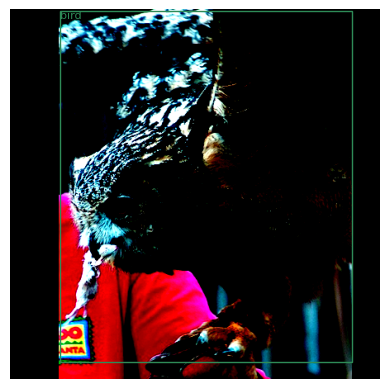

In [19]:
# 设置数据集路径
PASCAL_VOC_DIR_PATH = 'data/voc/VOC_Detection'  # 这里需要替换为你本地的 VOC 数据集路径

S = 7
D = 448  # 输入图像的尺寸。YOLOv1输入图像大小为448×448像素。这个参数定义了输入图像的宽度和高度。

# 数据增强超参数
HUE = 0.1  # 色相调整的范围。用于数据增强中的颜色变化，可以改变图像的色调。
SATURATION = 1.5  # 饱和度调整的范围。用于增强图像的饱和度，使图像色彩更加鲜艳或黯淡。
EXPOSURE = 1.5  # 曝光度调整的范围。用于改变图像的亮度，增强图像亮暗的变化。

RESIZE_PROB = 0.2  # 随机调整图像大小的概率。定义每个图像在数据增强时被调整大小的概率。
ZOOM_OUT_PROB = 0.4  # 随机缩小图像的概率。用于模拟目标被放大或缩小的场景。
ZOOM_IN_PROB = 0.4  # 随机放大图像的概率。通过在图像上执行缩放操作来增强数据。
JITTER = 0.2  # 图像随机抖动的强度。通过随机裁剪图像来改变图像内容，增强训练集的多样性。

dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                        split='train',
                        transforms=transforms.Compose([
                            RandomScaleTranslate(output_size=D,
                                                jitter=JITTER,
                                                resize_p=RESIZE_PROB,
                                                zoom_out_p=ZOOM_OUT_PROB,
                                                zoom_in_p=ZOOM_IN_PROB),
                            RandomColorJitter(hue=HUE,
                                            sat=SATURATION,
                                            exp=EXPOSURE),
                            RandomHorizontalFlip(p=0.5),
                            ToYOLOTensor(S=S,
                                        C=VOC_Detection.C,
                                        normalize=[[0.4549, 0.4341, 0.4010],
                                                    [0.2703, 0.2672, 0.2808]])]))

# 获取样本
img_tensor, yolo_target = dataset[0]

# 解码YOLO目标到边界框列表
def decode_yolo_target(yolo_target, S=7, C=20, image_size=448):
    boxes = []
    cell_size = image_size / S
    for i in range(S):
        for j in range(S):
            cell = yolo_target[i, j]
            if cell[0] == 1:  # 存在物体
                # 提取类别
                class_prob = cell[1:C+1]
                class_id = th.argmax(class_prob).item()
                # 中心坐标和宽高（归一化）
                cx, cy, bw, bh = cell[C+1:C+5]
                # 转换为绝对坐标
                cx_abs = (j * cell_size) + (cx * cell_size)
                cy_abs = (i * cell_size) + (cy * cell_size)
                bw_abs = bw * image_size
                bh_abs = bh * image_size
                # 计算边界框坐标
                xmin = cx_abs - bw_abs / 2
                ymin = cy_abs - bh_abs / 2
                xmax = cx_abs + bw_abs / 2
                ymax = cy_abs + bh_abs / 2
                boxes.append( (class_id, xmin, ymin, xmax, ymax) )
    return boxes

# 解码目标
decoded_boxes = decode_yolo_target(yolo_target, S=S, C=VOC_Detection.C, image_size=D)

# 打印解码后的边界框
print("解码后的边界框：")
for box in decoded_boxes:
    class_id, xmin, ymin, xmax, ymax = box
    print(f"类别: {dataset.index2label[class_id]}, 边界框: ({xmin:.1f}, {ymin:.1f}), ({xmax:.1f}, {ymax:.1f})")

# 显示图像和边界框
img = img_tensor.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')

for box in decoded_boxes:
    class_id, xmin, ymin, xmax, ymax = box
    # 绘制边界框
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                         linewidth=1, edgecolor=dataset.label_clrs[class_id], facecolor='none')
    plt.gca().add_patch(rect)
    # 添加类别标签
    plt.text(xmin, ymin, dataset.index2label[class_id], 
             color=dataset.label_clrs[class_id], fontsize=8, verticalalignment='top')

plt.show()


### 1.4 数据加载器的创建

In [21]:
from torch.utils.data import DataLoader

# 数据加载超参数
BATCH = 64  # 每个训练批次的样本数量。定义了每个训练步骤中使用的图像数量。
SUBDIVISIONS = 8  # 梯度累积的次数。这个值通常用于显存不足时，允许通过多个小批次的累积计算来减少内存开销。
NUM_WORKERS = 10  # 数据加载时使用的工作线程数量。这个参数决定了加载数据的并行处理数量，可以加速数据读取。
SHUFFLE = True  # 是否打乱数据。在每个epoch开始时，是否将训练数据打乱顺序，以提高训练效果。
PIN_MEMORY = True  # 是否将数据加载到固定内存中。如果为True，数据加载器将数据从CPU内存中预取到GPU，以加速GPU的数据处理。
DROP_LAST = True  # 是否丢弃最后一个批次。在数据加载过程中，如果数据不能完全组成一个批次，是否丢弃最后剩余的样本。

train_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                                split='train',
                                transforms=transforms.Compose([
                                    RandomScaleTranslate(output_size=D,
                                                        jitter=JITTER,
                                                        resize_p=RESIZE_PROB,
                                                        zoom_out_p=ZOOM_OUT_PROB,
                                                        zoom_in_p=ZOOM_IN_PROB),
                                    RandomColorJitter(hue=HUE,
                                                    sat=SATURATION,
                                                    exp=EXPOSURE),
                                    RandomHorizontalFlip(p=0.5),
                                    ToYOLOTensor(S=S,
                                                C=VOC_Detection.C,
                                                normalize=[[0.4549, 0.4341, 0.4010],
                                                            [0.2703, 0.2672, 0.2808]])]))

test_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                                split='test',
                                transforms=transforms.Compose([
                                    Resize(output_size=D),
                                    ToYOLOTensor(S=S,
                                                C=VOC_Detection.C,
                                                normalize=[[0.4549, 0.4341, 0.4010],
                                                            [0.2703, 0.2672, 0.2808]])]))

train_loader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH // SUBDIVISIONS,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY,
                            shuffle=SHUFFLE,
                            drop_last=DROP_LAST)

test_loader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH // SUBDIVISIONS,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

### 1.5 数据可视化

目标标签: tensor([[ 14., 320., 109., 364., 201.],
        [  0.,  83.,  95., 375., 375.],
        [  0., 340., 109., 465., 375.],
        [  0., 323., 118., 391., 375.]])
类别: bottle, 边界框: (320.0, 109.0), (364.0, 201.0)
类别: person, 边界框: (83.0, 95.0), (375.0, 375.0)
类别: person, 边界框: (340.0, 109.0), (465.0, 375.0)
类别: person, 边界框: (323.0, 118.0), (391.0, 375.0)


/tmp/ipykernel_488411/43943331.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)  # 将目标标签转换为 Tensor


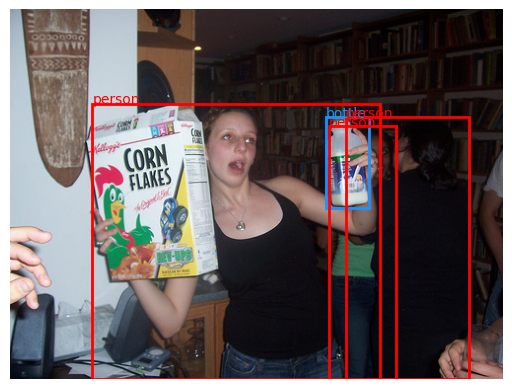

In [22]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

class ToTensorWithTarget:
    """
    自定义的变换类，将图像转换为 Tensor，同时将目标标签也转换为 Tensor。
    """

    def __call__(self, sample):
        img, target = sample
        img = transforms.ToTensor()(img)  # 将图片转换为 Tensor
        target = torch.tensor(target)  # 将目标标签转换为 Tensor
        return img, target


# 设置数据集路径
PASCAL_VOC_DIR_PATH = 'data/voc/VOC_Detection'  # 这里需要替换为你本地的 VOC 数据集路径

# 定义图像和目标标签的转换（自定义转换类）
transform = transforms.Compose([
    ToTensorWithTarget()  # 使用自定义的转换类
])

# 初始化 VOC 数据集
dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH, split='train', transforms=transform)

# 加载第一张图片和它的标签
img, target = dataset[1]  # 获取第一张图片和对应的目标标签

# 打印目标标签（bounding box的坐标和类别索引）
print("目标标签:", target)

for box in target:
    label = int(box[0].item())  # 将类别标签转换为整数
    xmin, ymin, xmax, ymax = box[1:].tolist()
    print(f"类别: {dataset.index2label[label]}, 边界框: ({xmin}, {ymin}), ({xmax}, {ymax})")

# 显示图像
img = img.permute(1, 2, 0)  # 转换为 (H, W, C) 格式以便展示
img = img.numpy()  # 转换为 NumPy 数组以便使用 Matplotlib 显示
plt.imshow(img)
plt.axis('off')  # 关闭坐标轴显示

# 画出目标框（bounding boxes）
for box in target:
    label = int(box[0].item())  # 将类别标签转换为整数
    xmin, ymin, xmax, ymax = box[1:].tolist()
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      linewidth=2, edgecolor=VOC_Detection.label_clrs[label], facecolor='none'))
    plt.text(xmin, ymin, dataset.index2label[label], fontsize=10, color=VOC_Detection.label_clrs[label])

plt.show()


## 2. 模型构建

### 2.1 定义 YOLO 的网络结构

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil, floor
from typing import Optional, List, Tuple, Union


In [24]:
class LocallyConnected2d(nn.Module):
    """
    局部连接的 2D 层，类似于 2D 卷积层，但不同之处在于权重**不共享**，
    每个窗口位置都有自己的一组权重。
    """
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 input_h: int,
                 input_w: int,
                 kernel_size: int,
                 stride: Optional[int] = 1,
                 padding: Optional[int] = 0) -> None:
        """
        初始化局部连接的 2D 层。
        输入张量的维度为 (N, C, H, W)，输出张量的维度为 (N, C', H', W')。
        
        其中：
        - C' = out_channels
        - H' = floor((H + 2 * padding - kernel_size) / stride + 1)
        - W' = floor((W + 2 * padding - kernel_size) / stride + 1)

        :param in_channels: 输入通道数
        :param out_channels: 输出通道数（滤波器个数）
        :param input_h: 输入图像的高度
        :param input_w: 输入图像的宽度
        :param kernel_size: 卷积核大小
        :param stride: 步长
        :param padding: 填充大小
        """
        super(LocallyConnected2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_h = floor((input_h + 2 * padding - kernel_size) / stride + 1)
        self.output_w = floor((input_w + 2 * padding - kernel_size) / stride + 1)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # 定义权重参数，每个位置都有独立的权重
        self.weight = nn.Parameter(torch.randn(1, self.in_channels, self.out_channels,
                                               self.output_h, self.output_w,
                                               self.kernel_size, self.kernel_size))

        # 定义偏置参数
        self.bias = nn.Parameter(torch.randn(1, self.out_channels, self.output_h, self.output_w))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        计算局部连接层的输出。
        每个窗口位置使用其独立的权重进行计算。

        :param x: 输入张量
        :return: 经过局部连接计算的输出张量
        """
        x = F.pad(x, (self.padding,) * 4)  # 填充输入图像
        windows = x.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)[:, :, None, ...]
        y = torch.sum(self.weight * windows, dim=[1, 5, 6]) + self.bias
        return y


In [ ]:
class ConvModule(nn.Module):
    def __init__(self, in_channels: int, module_config: List[Union[List, Tuple]]) -> None:
        super(ConvModule, self).__init__()
        self.layers = nn.ModuleList()  # 改为使用ModuleList管理子模块
        
        for sm_config in module_config:
            if isinstance(sm_config, tuple):
                in_channels = self._add_layer(in_channels, sm_config)
            elif isinstance(sm_config, list):
                sm_layers, r = sm_config
                for _ in range(r):
                    for layer_config in sm_layers:
                        in_channels = self._add_layer(in_channels, layer_config)
        self.out_channels = in_channels

    def _add_layer(self, in_channels: int, layer_config: Tuple) -> int:
        """确保所有层都被封装在Sequential中"""
        layer = None
        if layer_config[0] == 'c':
            kernel_size, out_channels = layer_config[1:3]
            stride = 1 if len(layer_config) == 3 else layer_config[3]
            padding = ceil((kernel_size - stride) / 2)
            
            layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1)
            )
            in_channels = out_channels
            
        elif layer_config[0] == 'p':
            kernel_size, stride = layer_config[1:]
            layer = nn.Sequential(
                nn.MaxPool2d(kernel_size, stride)
            )
            
        if layer is not None:
            self.layers.append(layer)
            
        return in_channels

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [34]:
class YOLOv1(nn.Module):
    """
    YOLOv1 目标检测模型。
    该模型在 ImageNet 2012 分类任务上进行预训练，然后在 PASCAL VOC 数据集上进行目标检测任务的微调。
    
    - `conv_backbone_config` 包含用于分类和检测任务的卷积模块。
    - `conv_detection_config` 仅用于目标检测任务的卷积模块。
    """
    conv_backbone_config = [[('c', 7, 64, 2), ('p', 2, 2)],
                            [('c', 3, 192), ('p', 2, 2)],
                            [('c', 1, 128), ('c', 3, 256), ('c', 1, 256), ('c', 3, 512), ('p', 2, 2)],
                            [[[('c', 1, 256), ('c', 3, 512)], 4], ('c', 1, 512), ('c', 3, 1024), ('p', 2, 2)],
                            [[[('c', 1, 512), ('c', 3, 1024)], 2]]]

    conv_detection_config = [[('c', 3, 1024), ('c', 3, 1024, 2)],
                             [('c', 3, 1024), ('c', 3, 1024)]]

    def __init__(self, S: int, B: int, C: int, mode: Optional[str] = 'detection') -> None:
        """
        YOLO 模型初始化。根据 `mode` 决定网络架构：
        
        - `detection` 模式包含骨干网络和检测头。
        - `classification` 模式包含骨干网络和分类头。

        :param S: 网格大小 (S x S)
        :param B: 每个网格单元预测的边界框数量
        :param C: 类别数
        :param mode: `detection` 进行目标检测，`classification` 进行分类
        """
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.mode = mode

        backbones_modules_list = []
        in_channels = 3
        for module_config in YOLOv1.conv_backbone_config:
            cm = ConvModule(in_channels, module_config)
            backbones_modules_list.append(cm)
            in_channels = cm.out_channels
        self.backbone = nn.Sequential(*backbones_modules_list)

        if mode == 'detection':
            head_modules_list = []
            for module_config in YOLOv1.conv_detection_config:
                cm = ConvModule(in_channels, module_config)
                head_modules_list.append(cm)
                in_channels = cm.out_channels
            detection_conv_modules = nn.Sequential(*head_modules_list)
            detection_fc_modules = nn.Sequential(LocallyConnected2d(in_channels, 256, 7, 7, 3, 1, 1),
                                                 nn.LeakyReLU(0.1),
                                                 nn.Flatten(),
                                                 nn.Dropout(p=0.5),
                                                 nn.Linear(256 * 7 * 7, S * S * (C + B * 5)))

            nn.init.kaiming_normal_(detection_fc_modules[0].weight, a=0.1, mode='fan_out')
            nn.init.zeros_(detection_fc_modules[0].bias)

            self.detection_head = nn.Sequential(detection_conv_modules,
                                                detection_fc_modules)
            self.forward = self._forward_detection

        elif mode == 'classification':
            self.classification_head = nn.Sequential(nn.AvgPool2d(7),
                                                     nn.Flatten(),
                                                     nn.Linear(1024, C))
            self.forward = self._forward_classification

    def _forward_classification(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播：通过骨干网络和分类头。

        :param x: 输入张量
        :return: 分类任务的输出
        """
        x = self.backbone(x)
        y = self.classification_head(x)
        return y

    def _forward_detection(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播：通过骨干网络和检测头。

        :param x: 输入张量
        :return: 目标检测任务的输出
        """
        x = self.backbone(x)
        x = self.detection_head(x)
        y = x.reshape(x.shape[0], self.S, self.S, self.C + self.B * 5)
        return y


### 2.2 模型前向推理数据可视化

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid


In [47]:
def register_layer_hooks(model: nn.Module) -> dict:
    """
    为模型的所有卷积层注册前向钩子，用于捕获特征图
    """
    layer_outputs = {}
    
    def get_hook(name):
        def hook(module, input, output):
            layer_outputs[name] = output.detach()
        return hook
    
    # 遍历所有子模块
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            # 处理Sequential容器中的嵌套层
            for sub_name, sub_module in module.named_children():
                full_name = f"{name}.{sub_name}"
                if isinstance(sub_module, ConvModule):
                    # 处理ConvModule中的卷积层
                    for layer_idx, layer in enumerate(sub_module.layers):
                        if isinstance(layer[0], nn.Conv2d):
                            layer_name = f"{full_name}.conv_{layer_idx}"
                            layer[0].register_forward_hook(get_hook(layer_name))
                else:
                    sub_module.register_forward_hook(get_hook(full_name))
        else:
            module.register_forward_hook(get_hook(name))
    
    return layer_outputs


def visualize_features(raw_img: torch.Tensor, 
                       layer_outputs: dict,
                       n_channels: int = 8,
                       figsize: tuple = (32, 48)) -> None:
    """
    可视化各层特征图
    
    参数说明：
    raw_img: 原始输入图像 tensor (C, H, W)
    layer_outputs: 各层输出字典
    n_channels: 每层显示的通道数
    figsize: 画布尺寸
    """
    plt.figure(figsize=figsize)
    
    # 显示原始图像
    plt.subplot(1 + len(layer_outputs), 1, 1)
    plt.imshow(raw_img.permute(1, 2, 0).numpy())
    plt.title("Original Image")
    plt.axis('off')
    
    # 可视化各层特征
    for i, (layer_name, features) in enumerate(layer_outputs.items()):
        # 选择前n_channels个通道
        channels = features[0, :n_channels]
        
        # 归一化到[0,1]范围
        min_val = channels.min()
        max_val = channels.max()
        channels = (channels - min_val) / (max_val - min_val + 1e-8)
        
        # 创建网格排列
        grid = make_grid(channels.unsqueeze(1), nrow=n_channels, padding=2)
        
        # 绘制特征图
        plt.subplot(1 + len(layer_outputs), 1, i+2)
        plt.imshow(grid.permute(1, 2, 0), cmap='viridis')
        plt.title(f"Layer: {layer_name}\nShape: {tuple(features.shape)}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



真实样本特征可视化：


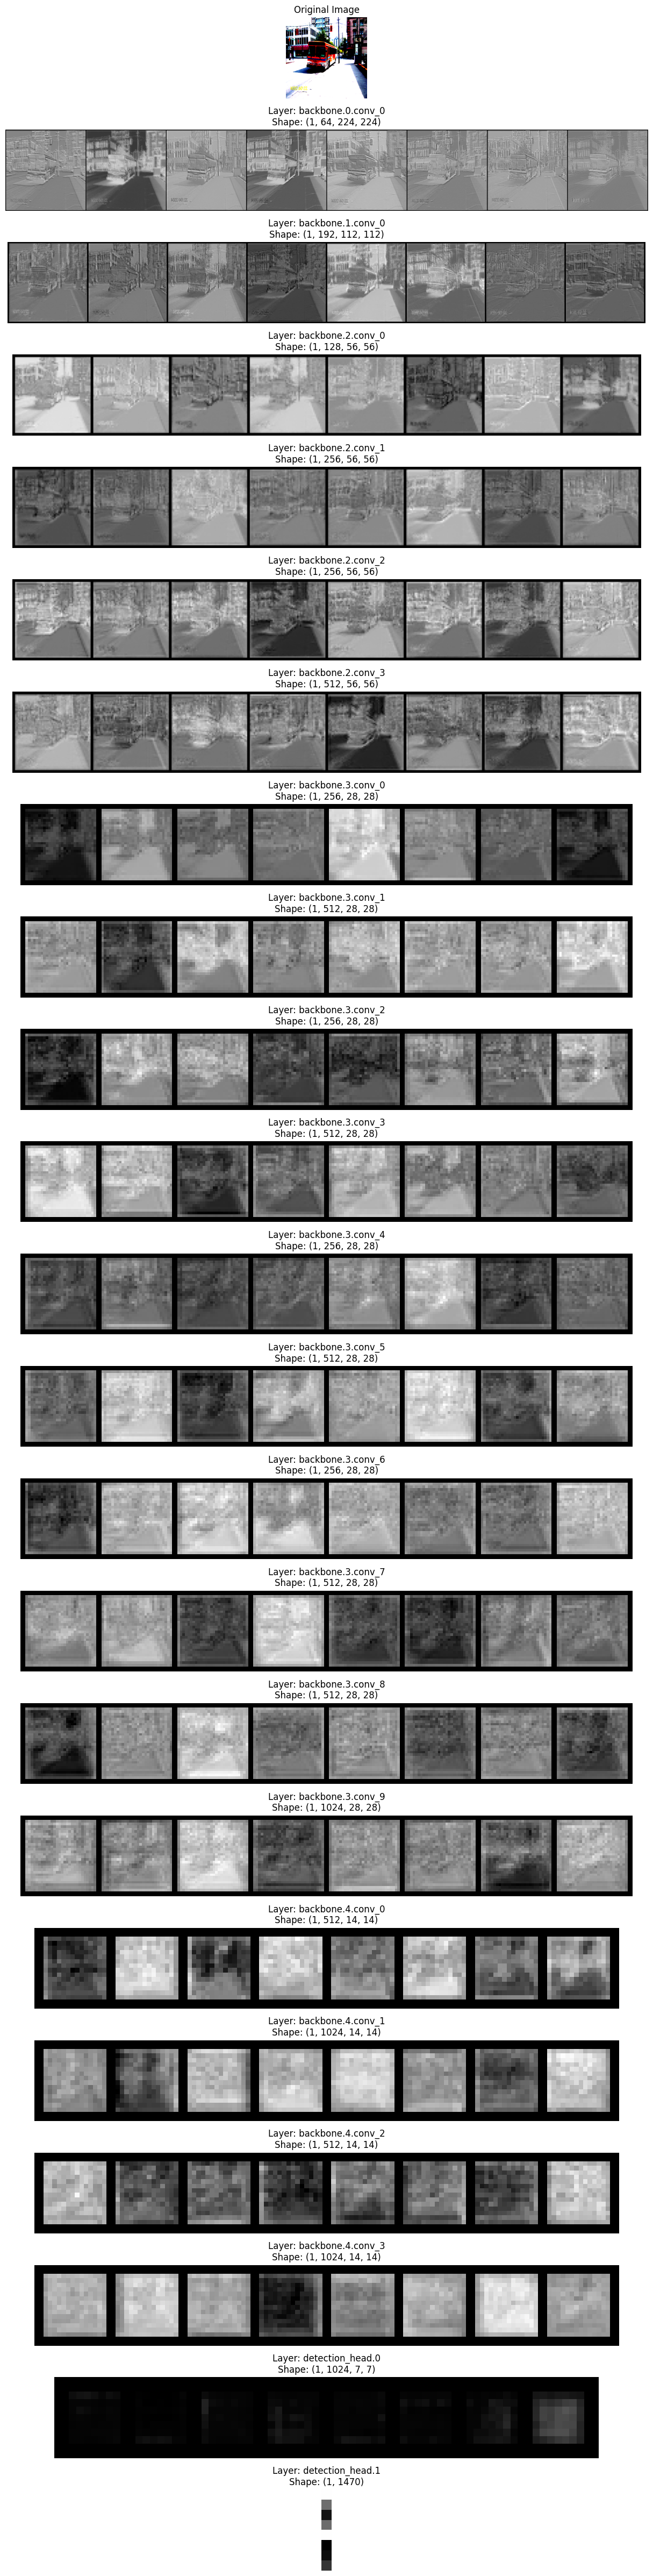

In [71]:
# 初始化模型
model = YOLOv1(S=7, B=2, C=20, mode='detection')
model.eval()
# 注册特征图钩子
layer_outputs = register_layer_hooks(model)

# 真实数据示例（需要正确配置数据集）
try:
    sample_idx = 10
    img, _ = train_dataset[sample_idx]
    
    # 重新注册钩子
    layer_outputs = register_layer_hooks(model)
    
    with torch.no_grad():
        _ = model(img.unsqueeze(0))
    
    print("\n真实样本特征可视化：")
    visualize_features(img, layer_outputs)
    
except Exception as e:
    print("\n无法加载真实数据集，错误信息：", str(e))

## 3. 损失函数

### 3.1 损失函数构建

In [49]:
import copy
import torch
import torch.nn as nn
from torch.nn.functional import one_hot

In [50]:
def get_bb_corners(bboxes_coords: torch.Tensor) -> torch.Tensor:
    """
    根据 YOLO 格式的边界框坐标计算边界框的四个角坐标。

    :param bboxes_coords: 包含 (x_center, y_center, width, height) 格式的边界框坐标的 Tensor。
    :return: 一个与 bboxes_coords 相同形状的 Tensor，包含 (xmin, ymin, xmax, ymax) 格式的边界框四个角坐标。
    """

    xmin = bboxes_coords[..., 0] - bboxes_coords[..., 2] / 2
    ymin = bboxes_coords[..., 1] - bboxes_coords[..., 3] / 2
    xmax = bboxes_coords[..., 0] + bboxes_coords[..., 2] / 2
    ymax = bboxes_coords[..., 1] + bboxes_coords[..., 3] / 2

    bb_corners = torch.stack([xmin, ymin, xmax, ymax], dim=-1)
    return bb_corners


In [51]:
def iou(bboxes1_coords: torch.Tensor, bboxes2_coords: torch.Tensor) -> torch.Tensor:
    """
    计算给定一组边界框的交并比 (IoU)。每个边界框的坐标以四个角的格式 (xmin, ymin, xmax, ymax) 给出。

    :param bboxes1_coords: 第一组边界框的坐标。
    :param bboxes2_coords: 第二组边界框的坐标。
    :return: 一个 Tensor，包含第一组和第二组边界框的交并比。
    """
    xmin = torch.max(bboxes1_coords[..., 0], bboxes2_coords[..., 0])
    ymin = torch.max(bboxes1_coords[..., 1], bboxes2_coords[..., 1])
    xmax = torch.min(bboxes1_coords[..., 2], bboxes2_coords[..., 2])
    ymax = torch.min(bboxes1_coords[..., 3], bboxes2_coords[..., 3])

    area_bb1 = (bboxes1_coords[..., 2] - bboxes1_coords[..., 0]) * (bboxes1_coords[..., 3] - bboxes1_coords[..., 1])
    area_bb2 = (bboxes2_coords[..., 2] - bboxes2_coords[..., 0]) * (bboxes2_coords[..., 3] - bboxes2_coords[..., 1])

    # 使用 clamp(min=0) 处理特殊情况：交集为0
    intersection = (xmax - xmin).clamp(min=0) * (ymax - ymin).clamp(min=0)
    union = area_bb1 + area_bb2 - intersection

    # 加上 1e-6 避免除以 0
    return intersection / (union + 1e-6)

In [52]:
class YOLO_Loss(nn.Module):
    """
    YOLO 损失函数的实现。YOLO 损失由三个部分组成：
    - 定位损失
    - 目标置信度损失
    - 分类损失
    """

    def __init__(self, S, C, B, D, L_coord, L_noobj):
        """
        初始化 YOLO 损失模块。

        L_coord 超参数用于调整定位误差与分类误差的权重，以最大化平均精度。否则，定位误差和分类误差的权重相等，这对模型优化不利。

        大多数网格单元中没有目标物体，这会导致这些单元的“置信度”接近零，从而影响包含物体的单元的梯度，甚至可能导致训练的不稳定。因此，L_noobj 超参数用于降低无物体网格单元的目标置信度损失。

        :param S: 每行/列的网格单元数。每张图像被划分为 (S x S) 的网格
        :param C: 类别数量
        :param B: YOLO 每个网格单元预测的边界框数量
        :param D: 输入图像的维度 (D x D) RGB 图像
        :param L_coord: L_coord 超参数
        :param L_noobj: L_noobj 超参数
        """
        super(YOLO_Loss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.D = D
        self.L_coord = L_coord
        self.L_noobj = L_noobj

        # YOLO 算法中每个 B 个边界框的索引
        self.register_buffer('pred_bb_ind', torch.arange(start=self.C, end=self.C + self.B * 5).reshape(self.B, 5))

    def forward(self, y_pred, y_gt):
        """
        YOLO 损失由定位误差、目标置信度误差和分类误差组成。这些误差使用平方和的形式计算，因为这样更容易优化。

        为了识别哪个预测框负责预测物体，我们需要计算预测框与真实框的交并比（IoU）。由于边界框的中心坐标和尺寸经过不同的归一化处理，直接计算四角坐标会导致错误的 IoU 评分。因此，我们首先计算归一化后的边界框四角坐标。

        具有最高 IoU 的框被选为负责预测的框。如果所有 B 个预测框与真实框没有交集，则选择误差最小的框（前提是误差小于 20）。否则，随机选择一个 B 个预测框。

        :param y_pred: YOLO 模型对于一个 mini-batch 的预测，形状为 (N, S, S, C+B*5)
        :param y_gt: 对应图像的真实标签，形状为 (N, S, S, C+5)
        :return: 给定预测和真实标签的 YOLO 损失
        """
        n = y_pred.shape[0]  # 获取批次的大小，即图片的数量
        exists_obj_i = y_gt[..., 0:1]  # 获取真实标签中物体存在的标记，0 表示没有物体，1 表示有物体
        gt_bboxes_coords = y_gt[..., None, self.C + 1:]  # 获取真实边界框坐标 (xmin, ymin, xmax, ymax)
        pred_bboxes_sqrt_coords = y_pred[..., self.pred_bb_ind[:, 1:]]  # 获取预测的边界框坐标（开方后的值）

        # 计算真实边界框的坐标并将其缩放到 [0, 1] 范围内
        gt_bboxes_scaled_coords = copy.deepcopy(gt_bboxes_coords.data)
        gt_bboxes_scaled_coords[..., :2] /= self.S  # 缩放中心坐标
        gt_bboxes_coords_corners = get_bb_corners(gt_bboxes_scaled_coords)  # 计算真实边界框的四角坐标

        # 计算预测边界框的坐标并将其缩放到 [0, 1] 范围内
        pred_bboxes_scaled_coords = copy.deepcopy(pred_bboxes_sqrt_coords.data)
        pred_bboxes_scaled_coords[..., :2] /= self.S  # 缩放中心坐标
        pred_bboxes_scaled_coords[..., 2:] *= pred_bboxes_scaled_coords[..., 2:]  # 将预测的宽高开方还原
        pred_bboxes_coords_corners = get_bb_corners(pred_bboxes_scaled_coords)  # 计算预测边界框的四角坐标

        # 计算真实框与预测框之间的交并比 (IoU)
        iou_scores = iou(gt_bboxes_coords_corners, pred_bboxes_coords_corners)
        max_iou_score, max_iou_index = torch.max(iou_scores, dim=-1)  # 获取与真实框最接近的预测框索引和 IoU 值

        # 计算真实框与预测框之间的均方根误差 (RMSE)
        rmse_scores = torch.sqrt(torch.sum((gt_bboxes_scaled_coords - pred_bboxes_scaled_coords) ** 2, dim=-1))
        min_rmse_scores, min_rmse_index = torch.min(rmse_scores, dim=-1)  # 获取误差最小的预测框索引和 RMSE 值
        rmse_mask = max_iou_score == 0  # 如果 IoU 为零，说明没有框与真实框有交集

        # 如果 IoU 为零，则选择 RMSE 最小的框，否则选择 IoU 最大的框
        best_index = max_iou_index
        best_index[rmse_mask] = min_rmse_index[rmse_mask]  # 对于 IoU 为零的情况，选择 RMSE 最小的框
        is_best_box = one_hot(best_index, self.B)  # 使用 one-hot 编码表示哪个框是最优框

        # 计算是否为目标框和是否为无目标框的标志
        exists_obj_ij = exists_obj_i * is_best_box  # 存在目标的框的标记
        exists_noobj_ij = 1 - exists_obj_ij  # 不存在目标的框的标记

        # 定位损失（计算中心位置的误差）
        localization_center_loss = self.L_coord * torch.sum(exists_obj_ij[..., None] * (
                (gt_bboxes_coords[..., 0:2] - pred_bboxes_sqrt_coords[..., 0:2]) ** 2))

        # 定位损失（计算边界框的宽度和高度的误差）
        localization_dims_loss = self.L_coord * torch.sum(exists_obj_ij[..., None] * (
                (torch.sqrt(gt_bboxes_coords[..., 2:4]) - pred_bboxes_sqrt_coords[..., 2:4]) ** 2))

        localization_loss = localization_center_loss + localization_dims_loss  # 总的定位损失

        # 目标置信度损失
        pred_bbox_cscores = y_pred[..., self.pred_bb_ind[:, 0]]  # 预测的置信度分数

        # 目标框的置信度损失
        objectness_obj_loss = torch.sum(exists_obj_ij * (iou_scores - pred_bbox_cscores) ** 2)
        # 无目标框的置信度损失
        objectness_noobj_loss = self.L_noobj * torch.sum(exists_noobj_ij * pred_bbox_cscores ** 2)

        objectness_loss = objectness_obj_loss + objectness_noobj_loss  # 总的目标置信度损失

        # 分类损失
        pred_bboxes_class = y_pred[..., :self.C]  # 预测的类别概率
        gt_bboxes_class = y_gt[..., 1:self.C + 1]  # 真实类别标签

        classification_loss = torch.sum(exists_obj_i * (gt_bboxes_class - pred_bboxes_class) ** 2)  # 分类损失

        # 平均 YOLO 损失
        total_loss = (localization_loss + objectness_loss + classification_loss) / n  # 计算总损失并取平均
        return total_loss


### 3.2 损失函数详解

#### 3.2.1 **类定义说明**
```python
class YOLO_Loss(nn.Module):
    def __init__(self, S, C, B, D, L_coord, L_noobj):
    def forward(self, y_pred, y_gt):
```

#### 3.2.2 **参数说明**
| 参数 | 类型 | 说明 |
| --- | --- | --- |
| `S` | int | 网格数量（图像被划分为 `S×S` 的网格）|
| `C` | int | 数据集类别数（如 VOC 有 20 类）|
| `B` | int | 每个网格预测的边界框数量（YOLOv1 默认 `B=2`）|
| `D` | int | 输入图像的尺寸（`D×D`，如 448×448）|
| `L_coord` | float | 定位损失的权重系数（建议值 `5.0`）|
| `L_noobj` | float | 无目标框置信度损失的权重系数（建议值 `0.5`）|

#### 3.2.3 **输入数据格式**
| 参数 | 形状 | 说明 |
| --- | --- | --- |
| `y_pred` | `(N, S, S, C+B*5)` | 模型预测值 | 
| `y_gt` | `(N, S, S, C+5)` | 真实标签 |

**字段解释**：
- **`y_gt` 结构**：  
  ```python
  y_gt[i,j,k] = [存在目标标志, 类别 one-hot 编码, x_center, y_center, width, height]
  ```
  - 存在目标标志：`0`（无目标）或 `1`（有目标）
  - 坐标值需归一化到 `[0,1]` 范围（相对于图像尺寸）

- **`y_pred` 结构**：  
  ```python
  y_pred[i,j,k] = [类别概率, B组(置信度, x_center, y_center, sqrt(width), sqrt(height))]
  ```
  - 宽度和高度需预测平方根值（缓解大目标梯度爆炸）

#### 3.2.3 **调用示例**

In [53]:
# 初始化损失函数
criterion = YOLO_Loss(
    S=7, 
    C=20, 
    B=2, 
    D=448,
    L_coord=5.0, 
    L_noobj=0.5
)

# 模拟输入数据
batch_size = 4
y_pred = torch.randn(batch_size, 7, 7, 30)  # 30 = 20类 + 2 * 5预测框
y_gt = torch.zeros(batch_size, 7, 7, 25)     # 25 = 1存在标志 + 20类 + 4坐标

# 随机生成有目标的网格
for n in range(batch_size):
    i, j = torch.randint(0,7, (2,))
    y_gt[n, i, j, 0] = 1.0                   # 标记存在目标
    y_gt[n, i, j, 1:21] = one_hot(torch.randint(0,20, (1,)), 20) # 随机类别
    y_gt[n, i, j, 21:] = torch.FloatTensor([0.3, 0.5, 0.2, 0.4]) # 随机坐标 (x,y,w,h)

# 计算损失
loss = criterion(y_pred, y_gt)
print(f"Total Loss: {loss.item():.4f}")

Total Loss: 94.0165


#### 3.2.4 **输出说明**
- **返回值**：标量 Tensor，包含三项损失的加权和：
  ```python
  loss = (定位损失 + 置信度损失 + 分类损失) / batch_size
  ```
- **典型值范围**：初始训练时约 `5.0~10.0`，收敛后约 `1.0~3.0`



#### 3.2.5 **关键实现逻辑**
1. **最优框选择**：
   - 计算预测框与真实框的 IoU，选择 IoU 最大的框
   - 若所有 IoU=0，则选择与真实框坐标误差（RMSE）最小的框

2. **损失项计算**：
   - **定位损失**：仅作用于最优框的中心坐标和尺寸
   - **置信度损失**：
     - 有目标框：`(IoU - 预测置信度)^2`
     - 无目标框：`L_noobj * (预测置信度)^2`
   - **分类损失**：有目标框的类别交叉熵


### 3.3 定义优化器

In [56]:
import torch.optim as opt

In [57]:
# 训练超参数
INIT_LR = 0.0005  # 初始学习率。训练开始时的学习率，影响模型参数更新的步伐。
BURN_IN = 100  # 预热阶段的批次数。在训练的初期，学习率逐渐增大，这有助于避免模型的梯度爆炸。
BURN_IN_POW = 2.0  # 预热学习率增长的幂次。该参数控制学习率增加的速率，较高的值表示更快的学习率增长。
LR_SCHEDULE = [(750, 2.0),  # 学习率调度表。包含一组元组，表示在特定步数（如750）时，学习率的缩放因子（如2.0）。
               (1500, 2.0),
               (2250, 1.25),
               (3250, 1.60),
               (5500, 1.25),
               (15000, 0.8),
               (20000, 0.625),
               (25000, 0.8),
               (30000, 0.5),
               (35000, 0.5)]
MOMENTUM = 0.9  # 动量。动量是优化算法的一种技术，它能加速梯度下降，避免陷入局部最小值。
WEIGHT_DECAY = 0.0005  # 权重衰减（L2正则化）。防止模型过拟合的正则化方法，它通过加权的方式约束模型的参数值。

optimizer = opt.SGD(params=model.parameters(),
                    lr=INIT_LR * (1/BURN_IN)**BURN_IN_POW,
                    momentum=MOMENTUM,
                    weight_decay=WEIGHT_DECAY)

### 3.4 定义调度器

In [59]:
class MultiStepScaleLR:
    """
    MultiStepScaleLR类实现了一个自定义的学习率调度器。对于前几次权重更新，学习率会逐步增加以避免发散。
    在这些预热批次之后，学习率会根据设定的步长和相应的缩放因子进行调整。
    """
    def __init__(self,
                 optimizer: opt.SGD,
                 init_lr: float,
                 lr_schedule: List[Tuple[int, float]],
                 burn_in: int,
                 burn_in_pow: float) -> None:
        """
        初始化MultiStepScaleLR对象。保存优化器、学习率调度步长及其对应的缩放因子，预热批次和预热幂次等信息。
        初始化一个批次计数器来跟踪网络的权重更新次数，并且初始化一个变量指向下一个学习率调整的步长。

        :param optimizer: 使用的SGD优化器
        :param init_lr: 预热阶段后的初始学习率
        :param lr_schedule: 学习率调整的步长及相应的缩放因子
        :param burn_in: 训练开始时，学习率逐步增加的批次数
        :param burn_in_pow: 学习率增加的幂次，控制增长的速率
        """
        self.optimizer = optimizer
        self.steps, self.scales = zip(*lr_schedule)
        self.burn_in = burn_in
        self.init_lr = init_lr
        self.pow = burn_in_pow
        self.batch = 0
        self.next_step_ind = 0

    def step(self) -> None:
        """
        更新优化器的学习率。在前几个预热批次中，学习率逐步增加以达到设定的init_lr。
        之后，学习率会根据给定步长及缩放因子进行调整。
        """
        self.batch += 1
        if self.batch < self.burn_in:
            self.optimizer.param_groups[0]['lr'] = self.init_lr * ((self.batch+1)/self.burn_in)**self.pow
        elif self.next_step_ind < len(self.steps) and self.batch == self.steps[self.next_step_ind]:
            self.optimizer.param_groups[0]['lr'] *= self.scales[self.next_step_ind]
            self.next_step_ind += 1

    def state_dict(self) -> dict:
        """
        返回对象的状态字典，可以用来恢复训练（LOAD_MODEL='train'时）。

        :return: 一个字典，包含类的成员和对应的值。优化器不包含在字典中。
        """
        return {key: value for (key, value) in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict: dict) -> None:
        """
        加载给定的状态字典，用于恢复训练（LOAD_MODEL='train'时）。

        :param state_dict: 一个字典，包含类的成员和对应的值。优化器不包含在字典中。
        """
        self.__dict__.update(state_dict)

In [60]:
scheduler = MultiStepScaleLR(optimizer,
                            init_lr=INIT_LR,
                            lr_schedule=LR_SCHEDULE,
                            burn_in=BURN_IN,
                            burn_in_pow=BURN_IN_POW)

### 3.5. 定义评估器

In [63]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transforms import Resize, ImgToTensor
from typing import List, Tuple, Literal
import matplotlib.pyplot as plt
from configs import *

In [64]:
def get_detected_boxes(y: torch.Tensor, prob_threshold: float, conf_mode: Literal['objectness', 'class']) -> torch.Tensor:
    """
    处理 YOLOv1 模型的输出，筛选预测框。
    计算每个网格单元 B 个边界框中最高的 IOU 预测框，若其置信度低于 `prob_threshold`，则丢弃。
    
    :param y: YOLOv1 模型的输出，边界框坐标已转换为角落格式。
    :param prob_threshold: 丢弃概率低于该阈值的边界框。
    :param conf_mode: 计算置信度的模式。
    :return: 经过筛选后的边界框信息。
    """
    assert conf_mode in ['objectness', 'class']
    
    y[..., :VOC_Detection.C] = F.softmax(y[..., :VOC_Detection.C], dim=-1)
    class_score, class_ind = torch.max(y[..., :VOC_Detection.C], dim=-1)
    objectness, bboxes_ind = torch.max(y[..., [VOC_Detection.C + i * 5 for i in range(B)]], dim=-1)
    bboxes_coords_ind = torch.arange(4, device=DEVICE)[None, None, None, :] + VOC_Detection.C + bboxes_ind[..., None] * 5 + 1
    bboxes_coords = torch.gather(y, dim=-1, index=bboxes_coords_ind)
    detection_mask = (objectness > prob_threshold)
    
    det_class_ind = class_ind[detection_mask].reshape(-1, 1)
    if conf_mode == 'class':
        det_conf = (class_score[detection_mask] * objectness[detection_mask]).reshape(-1, 1)
    else:
        det_conf = objectness[detection_mask].reshape(-1, 1)
    
    bb_corners = get_bb_corners(bboxes_coords).clamp(min=0, max=D)
    mask_gcs = detection_mask[..., None].expand(-1, -1, -1, 4)
    det_bb_corners = bb_corners[mask_gcs].reshape(-1, 4)
    
    boxes = torch.cat([det_class_ind, det_conf, det_bb_corners], dim=-1)
    return boxes

In [65]:
def non_max_suppression(boxes: torch.Tensor, nms_threshold: float) -> torch.Tensor:
    """
    进行非极大值抑制（NMS），去除重叠度较高的低置信度目标框。
    当两个边界框属于相同类别，并且它们的 IOU（交并比）大于或等于 nms_threshold 时，
    仅保留置信度最高的框，其余框会被丢弃。

    :param boxes: 单张图片的预测边界框，每个框包括类别、置信度及四个角坐标。
    :param nms_threshold: 非极大值抑制的阈值，超过该阈值的重叠框将被去除。
    :return: 经过非极大值抑制处理后的边界框。
    """
    nms_boxes = []
    # 按置信度降序排序
    sort_ind = torch.argsort(boxes[:, 1], descending=True)
    boxes = boxes[sort_ind, :]
    
    while len(boxes):
        box1, boxes = boxes[0], boxes[1:]
        nms_boxes.append(box1)

        box1_class, box1_coords = box1[0], box1[2:]
        iou_scores = torch.zeros(len(boxes), device=DEVICE)
        same_class = box1_class == boxes[:, 0]  # 仅计算相同类别的 IOU
        iou_scores[same_class] = iou(box1_coords, boxes[same_class][:, 2:])
        valid_boxes = iou_scores < nms_threshold  # 仅保留 IOU 低于阈值的框
        boxes = boxes[valid_boxes]
    
    if len(nms_boxes):
        boxes = torch.stack(nms_boxes, dim=0)
    else:
        boxes = torch.empty((0, 6), device=DEVICE)  # 无有效框时返回空张量
    return boxes

In [66]:
def rescale_bboxes(y: torch.Tensor) -> None:
    """
    将 YOLO 模型预测的归一化边界框坐标转换为实际坐标。
    YOLO 预测的边界框格式为 (x_center_norm, y_center_norm, sqrt(width_norm), sqrt(height_norm))，
    其中中心坐标是相对于网格单元大小归一化的，宽高是相对于输入图像尺寸归一化的。
    该函数用于反归一化，转换为 (x_center, y_center, width, height)。

    :param y: YOLOv1 模型的预测输出。
    """
    row, col = torch.meshgrid(torch.arange(S, device=DEVICE),
                              torch.arange(S, device=DEVICE), indexing='ij')
    row = row.unsqueeze(-1)
    col = col.unsqueeze(-1)

    # 反归一化中心坐标
    y[..., [VOC_Detection.C + i * 5 + 1 for i in range(B)]] += col
    y[..., [VOC_Detection.C + i * 5 + 2 for i in range(B)]] += row
    y[..., [VOC_Detection.C + i * 5 + j for j in [1, 2] for i in range(B)]] *= D / S

    # 反归一化宽高
    y[..., [VOC_Detection.C + i * 5 + j for j in [3, 4] for i in range(B)]] *= (
        D * y[..., [VOC_Detection.C + i * 5 + j for j in [3, 4] for i in range(B)]])

In [67]:
def postprocessing(y: torch.Tensor, prob_threshold: float, conf_mode: Literal['objectness', 'class'], nms_threshold: float) -> torch.Tensor:
    """
    进行目标检测后处理，包括边界框反归一化、筛选最佳目标框，并应用非极大值抑制。

    :param y: YOLOv1 模型的输出。
    :param prob_threshold: 置信度阈值，低于该阈值的边界框将被丢弃。
    :param conf_mode: 置信度计算方式，可选 'objectness' 或 'class'。
    :param nms_threshold: 非极大值抑制的阈值。
    :return: 经过处理的目标框，每行包含类别、置信度及 (xmin, ymin, xmax, ymax) 坐标。
    """
    rescale_bboxes(y)  # 反归一化边界框坐标
    boxes = get_detected_boxes(y, prob_threshold, conf_mode)  # 获取符合置信度要求的边界框
    boxes = non_max_suppression(boxes, nms_threshold)  # 进行非极大值抑制
    return boxes

In [68]:
def evaluate_predictions(bboxes_gt: torch.Tensor, bboxes_pred: torch.Tensor, prob_threshold: float) -> torch.Tensor:
    """
    评估预测的边界框是否与真实边界框匹配。
    每个真实框最多只能匹配一个预测框，匹配要求 IOU 大于 IOU_THRESHOLD 且类别相同。
    置信度最高的预测框优先匹配。

    :param bboxes_gt: 真实边界框，包含类别、xmin、ymin、xmax、ymax。
    :param bboxes_pred: 预测边界框，包含类别、置信度、xmin、ymin、xmax、ymax。
    :param prob_threshold: 置信度阈值，低于该阈值的边界框将被丢弃。
    :return: 1D 张量，长度等于预测框数。匹配的预测框值为 1，否则为 0。
    """
    n_pred = bboxes_pred.shape[0]
    true_predictions = torch.zeros(n_pred, device=DEVICE)

    for pbox_ind, pbox in enumerate(bboxes_pred):
        n_gt = bboxes_gt.shape[0]
        pbox_coords = pbox[2:]
        bboxes_gt_coords = bboxes_gt[:, 1:]
        pbox_class_ind = pbox[0].long()
        bboxes_gt_class_ind = bboxes_gt[:, 0].long()

        iou_scores = torch.zeros(n_gt, device=DEVICE)
        same_class = pbox_class_ind == bboxes_gt_class_ind
        iou_scores[same_class] = iou(pbox_coords, bboxes_gt_coords[same_class])

        if iou_scores.shape[0]:
            best_iou, gt_box_ind = torch.max(iou_scores, dim=0)
            if best_iou > prob_threshold:
                true_predictions[pbox_ind] = 1
                bboxes_gt = bboxes_gt[torch.arange(n_gt, device=DEVICE) != gt_box_ind]

    return true_predictions


## 4. 训练过程

### 4.1 训练循环的实现

In [69]:
import torch
import torchvision.transforms as transforms
import torch.optim as opt
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import List, Tuple, Dict
import time
from transforms import RandomScaleTranslate, Resize, RandomColorJitter, RandomHorizontalFlip, ToYOLOTensor
from configs import *

In [ ]:
def train_epoch(train_loader: DataLoader,
                model: YOLOv1,
                optimizer: opt.SGD,
                criterion: YOLO_Loss,
                scheduler: MultiStepScaleLR,
                mini_batch: int) -> Tuple[float, int]:
    """
    训练YOLO模型一个epoch，并返回该epoch每个训练实例的平均损失。

    :param train_loader: PASCAL VOC训练集的数据加载器
    :param model: YOLOv1检测模型
    :param optimizer: 使用的SGD优化器
    :param criterion: YOLO损失函数
    :param scheduler: 学习率调度器
    :param mini_batch: 当前小批次计数器
    :return: 当前epoch的平均训练损失和更新后的mini_batch计数器
    """
    av_loss = 0.

    model.train()
    for x, y_gt in train_loader:
        mini_batch += 1
        x, y_gt = x.to(DEVICE), y_gt.to(DEVICE)
        y_pred = model(x)
        loss = criterion(y_pred, y_gt) / SUBDIVISIONS
        loss.backward()

        if mini_batch == SUBDIVISIONS:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            mini_batch = 0

        av_loss += loss.item() * SUBDIVISIONS

    av_loss /= len(train_loader)
    return av_loss, mini_batch


def validate_epoch(val_loader: DataLoader,
                   model: YOLOv1,
                   criterion: YOLO_Loss) -> float:
    """
    验证YOLO模型，并返回该epoch每个测试实例的平均损失。

    :param val_loader: PASCAL VOC测试集的数据加载器
    :param model: YOLOv1检测模型
    :param criterion: YOLO损失函数
    :return: 当前epoch的平均测试损失
    """
    av_loss = 0.
    with torch.no_grad():
        model.eval()
        for x, y_gt in val_loader:
            x, y_gt = x.to(DEVICE), y_gt.to(DEVICE)
            y_pred = model(x)
            loss = criterion(y_pred, y_gt)
            av_loss += loss.item()

    av_loss /= len(val_loader)
    return av_loss


def train(train_loader: DataLoader,
          test_loader: DataLoader,
          model: YOLOv1,
          optimizer: torch.optim.SGD,
          criterion: YOLO_Loss,
          scheduler: MultiStepScaleLR,
          epoch: int,
          mini_batch: int,
          train_loss_history: List[float],
          test_loss_history: List[float]) -> None:
    """
    训练YOLOv1模型，直到达到最大epoch数MAX_EPOCHS。每隔CHECKPOINT_T个epoch保存一次检查点。
    训练结束后保存最终模型。

    :param train_loader: PASCAL VOC训练集的数据加载器
    :param test_loader: PASCAL VOC测试集的数据加载器
    :param model: YOLOv1检测模型
    :param optimizer: 使用的SGD优化器
    :param criterion: YOLO损失函数
    :param scheduler: 学习率调度器
    :param epoch: 当前训练的epoch
    :param mini_batch: 当前小批次计数器
    :param train_loss_history: 训练过程中每个epoch的损失历史
    :param test_loss_history: 测试过程中每个epoch的损失历史
    """
    pbar = tqdm(total=MAX_EPOCHS, desc='训练Epoch', initial=epoch, unit='epoch', position=0, leave=True)
    if mini_batch == 0:
        optimizer.zero_grad()

    while epoch < MAX_EPOCHS:
        start_time = time.time()  # 记录epoch开始的时间
        epoch += 1

        # 训练一个epoch并获取训练损失
        train_loss, mini_batch = train_epoch(train_loader, model, optimizer, criterion, scheduler, mini_batch)
        # 验证一个epoch并获取测试损失
        test_loss = validate_epoch(test_loader, model, criterion)

        # 保存损失历史
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        # 保存检查点
        if epoch % CHECKPOINT_T == 0:
            torch.save({'epoch': epoch,
                        'mini_batch': mini_batch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'train_loss_history': train_loss_history,
                        'test_loss_history': test_loss_history,
                        'grads': {p[0]: p[1].grad for p in model.named_parameters()}
                        }, TRAINING_CHECKPOINT_PATH)

        # 计算当前epoch的耗时
        epoch_time = time.time() - start_time
        # 获取当前学习率
        current_lr = optimizer.param_groups[0]['lr']  # 假设学习率保存在optimizer的param_groups中

        # # 打印日志
        # print(f"Epoch {epoch}/{MAX_EPOCHS}:")
        # print(f"  训练损失: {train_loss:.3f}, 测试损失: {test_loss:.3f}")
        # print(f"  当前学习率: {current_lr:.6f}")
        # print(f"  本轮训练耗时: {epoch_time:.2f}s")
        # print("-" * 50)

        # 更新进度条显示信息
        pbar.set_postfix_str(f'Training loss = {train_loss:.3f}, Test loss = {test_loss:.3f}, Current learning rate = {current_lr:.6f}, Time elapsed = {epoch_time:.2f}s')
        pbar.update(1)

        # 调度器更新
        scheduler.step()

    # 保存最终模型
    torch.save(model.state_dict(), TRAINED_MODEL_WEIGHTS)
    pbar.close()


def setup_train():
    """
    初始化模型、优化器、学习率调度器、损失函数以及PASCAL VOC数据集的训练和测试加载器。

    :return: 训练集和测试集的DataLoader对象，YOLOv1检测模型，SGD优化器，学习率调度器和YOLO损失函数
    """
    model = YOLOv1(S=S,
                   B=B,
                   C=VOC_Detection.C).to(DEVICE)

    optimizer = opt.SGD(params=model.parameters(),
                        lr=INIT_LR * (1/BURN_IN)**BURN_IN_POW,
                        momentum=MOMENTUM,
                        weight_decay=WEIGHT_DECAY)

    scheduler = MultiStepScaleLR(optimizer,
                                 init_lr=INIT_LR,
                                 lr_schedule=LR_SCHEDULE,
                                 burn_in=BURN_IN,
                                 burn_in_pow=BURN_IN_POW)

    criterion = YOLO_Loss(S=S,
                          C=VOC_Detection.C,
                          B=B,
                          D=D,
                          L_coord=L_COORD,
                          L_noobj=L_NOOBJ).to(DEVICE)

    train_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                                  split='train',
                                  transforms=transforms.Compose([
                                      RandomScaleTranslate(output_size=D,
                                                           jitter=JITTER,
                                                           resize_p=RESIZE_PROB,
                                                           zoom_out_p=ZOOM_OUT_PROB,
                                                           zoom_in_p=ZOOM_IN_PROB),
                                      RandomColorJitter(hue=HUE,
                                                        sat=SATURATION,
                                                        exp=EXPOSURE),
                                      RandomHorizontalFlip(p=0.5),
                                      ToYOLOTensor(S=S,
                                                   C=VOC_Detection.C,
                                                   normalize=[[0.4549, 0.4341, 0.4010],
                                                              [0.2703, 0.2672, 0.2808]])]))

    test_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                                 split='test',
                                 transforms=transforms.Compose([
                                     Resize(output_size=D),
                                     ToYOLOTensor(S=S,
                                                  C=VOC_Detection.C,
                                                  normalize=[[0.4549, 0.4341, 0.4010],
                                                             [0.2703, 0.2672, 0.2808]])]))

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH // SUBDIVISIONS,
                              num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY,
                              shuffle=SHUFFLE,
                              drop_last=DROP_LAST)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH // SUBDIVISIONS,
                             num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY)

    return train_loader, test_loader, model, optimizer, scheduler, criterion


def init_train(model: YOLOv1,
               optimizer: opt.SGD,
               scheduler: MultiStepScaleLR) -> Tuple[int, int, List[float], List[float]]:
    """
    初始化epoch、训练和验证损失历史记录、模型、优化器和学习率调度器。

    :param model: YOLOv1（或预训练模型）
    :param optimizer: 使用的SGD优化器
    :param scheduler: 学习率调度器
    :return: 当前epoch、mini-batch计数器，以及训练和测试损失历史
    """
    if LOAD_MODEL is None:
        epoch = 0
        mini_batch = 0
        train_loss_history = []
        test_loss_history = []

    elif LOAD_MODEL == 'pretrain':
        pretrained_model_weights = torch.load(PRETRAINED_MODEL_WEIGHTS)
        model.load_state_dict(pretrained_model_weights, strict=False)
        epoch = 0
        mini_batch = 0
        train_loss_history = []
        test_loss_history = []

    elif LOAD_MODEL == 'train':
        checkpoint = torch.load(TRAINING_CHECKPOINT_PATH)

        epoch = checkpoint['epoch']
        mini_batch = checkpoint['mini_batch']
        train_loss_history = checkpoint['train_loss_history']
        test_loss_history = checkpoint['test_loss_history']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        for p in model.named_parameters():
            p[1].grad = checkpoint['grads'][p[0]]

    else:
        assert 0

    return epoch, mini_batch, train_loss_history, test_loss_history


In [ ]:
train_loader, test_loader, model, optimizer, scheduler, criterion = setup_train()
epoch, mini_batch, train_loss_hist, test_loss_hist = init_train(model, optimizer, scheduler)

train(train_loader, test_loader, model, optimizer, criterion, scheduler,
      epoch, mini_batch,train_loss_hist, test_loss_hist)

训练Epoch:   1%|          | 1/156 [02:20<6:02:08, 140.18s/epoch, 训练损失=7.125, 测试损失=4.574, 当前学习率=0.000500, 耗时=140.18s]

Epoch 1/156:
  训练损失: 7.125, 测试损失: 4.574
  当前学习率: 0.000500
  本轮训练耗时: 140.18s
--------------------------------------------------


训练Epoch:   1%|▏         | 2/156 [04:40<5:59:39, 140.13s/epoch, 训练损失=4.704, 测试损失=4.417, 当前学习率=0.000500, 耗时=140.08s]

Epoch 2/156:
  训练损失: 4.704, 测试损失: 4.417
  当前学习率: 0.000500
  本轮训练耗时: 140.08s
--------------------------------------------------


训练Epoch:   2%|▏         | 3/156 [07:00<5:57:35, 140.23s/epoch, 训练损失=4.551, 测试损失=4.409, 当前学习率=0.001000, 耗时=140.36s]

Epoch 3/156:
  训练损失: 4.551, 测试损失: 4.409
  当前学习率: 0.001000
  本轮训练耗时: 140.36s
--------------------------------------------------


训练Epoch:   3%|▎         | 4/156 [09:20<5:55:11, 140.21s/epoch, 训练损失=4.564, 测试损失=4.471, 当前学习率=0.001000, 耗时=140.16s]

Epoch 4/156:
  训练损失: 4.564, 测试损失: 4.471
  当前学习率: 0.001000
  本轮训练耗时: 140.16s
--------------------------------------------------


训练Epoch:   3%|▎         | 5/156 [11:40<5:52:46, 140.18s/epoch, 训练损失=4.460, 测试损失=4.764, 当前学习率=0.001000, 耗时=140.12s]

Epoch 5/156:
  训练损失: 4.460, 测试损失: 4.764
  当前学习率: 0.001000
  本轮训练耗时: 140.12s
--------------------------------------------------


训练Epoch:   4%|▍         | 6/156 [14:01<5:50:31, 140.21s/epoch, 训练损失=4.389, 测试损失=4.603, 当前学习率=0.002000, 耗时=140.28s]

Epoch 6/156:
  训练损失: 4.389, 测试损失: 4.603
  当前学习率: 0.002000
  本轮训练耗时: 140.28s
--------------------------------------------------


训练Epoch:   4%|▍         | 7/156 [16:21<5:48:10, 140.21s/epoch, 训练损失=4.446, 测试损失=9.104, 当前学习率=0.002000, 耗时=140.19s]

Epoch 7/156:
  训练损失: 4.446, 测试损失: 9.104
  当前学习率: 0.002000
  本轮训练耗时: 140.19s
--------------------------------------------------


训练Epoch:   5%|▌         | 8/156 [18:41<5:45:53, 140.23s/epoch, 训练损失=4.388, 测试损失=5.715, 当前学习率=0.002000, 耗时=140.26s]

Epoch 8/156:
  训练损失: 4.388, 测试损失: 5.715
  当前学习率: 0.002000
  本轮训练耗时: 140.26s
--------------------------------------------------


训练Epoch:   6%|▌         | 9/156 [21:01<5:43:29, 140.20s/epoch, 训练损失=4.297, 测试损失=4.988, 当前学习率=0.002500, 耗时=140.14s]

Epoch 9/156:
  训练损失: 4.297, 测试损失: 4.988
  当前学习率: 0.002500
  本轮训练耗时: 140.14s
--------------------------------------------------


训练Epoch:   6%|▋         | 10/156 [23:24<5:43:08, 141.02s/epoch, 训练损失=4.339, 测试损失=6.418, 当前学习率=0.002500, 耗时=142.85s]

Epoch 10/156:
  训练损失: 4.339, 测试损失: 6.418
  当前学习率: 0.002500
  本轮训练耗时: 142.85s
--------------------------------------------------


训练Epoch:   7%|▋         | 11/156 [25:44<5:40:14, 140.79s/epoch, 训练损失=4.244, 测试损失=4.922, 当前学习率=0.002500, 耗时=140.27s]

Epoch 11/156:
  训练损失: 4.244, 测试损失: 4.922
  当前学习率: 0.002500
  本轮训练耗时: 140.27s
--------------------------------------------------


训练Epoch:   8%|▊         | 12/156 [28:05<5:37:28, 140.62s/epoch, 训练损失=4.157, 测试损失=8.862, 当前学习率=0.002500, 耗时=140.21s]

Epoch 12/156:
  训练损失: 4.157, 测试损失: 8.862
  当前学习率: 0.002500
  本轮训练耗时: 140.21s
--------------------------------------------------


训练Epoch:   8%|▊         | 13/156 [30:25<5:34:56, 140.54s/epoch, 训练损失=4.218, 测试损失=6.232, 当前学习率=0.004000, 耗时=140.36s]

Epoch 13/156:
  训练损失: 4.218, 测试损失: 6.232
  当前学习率: 0.004000
  本轮训练耗时: 140.36s
--------------------------------------------------


训练Epoch:   9%|▉         | 14/156 [32:45<5:32:22, 140.44s/epoch, 训练损失=4.242, 测试损失=5.700, 当前学习率=0.004000, 耗时=140.22s]

Epoch 14/156:
  训练损失: 4.242, 测试损失: 5.700
  当前学习率: 0.004000
  本轮训练耗时: 140.22s
--------------------------------------------------


训练Epoch:  10%|▉         | 15/156 [35:06<5:29:55, 140.39s/epoch, 训练损失=4.161, 测试损失=6.952, 当前学习率=0.004000, 耗时=140.27s]

Epoch 15/156:
  训练损失: 4.161, 测试损失: 6.952
  当前学习率: 0.004000
  本轮训练耗时: 140.27s
--------------------------------------------------


训练Epoch:  10%|█         | 16/156 [37:26<5:27:37, 140.41s/epoch, 训练损失=4.112, 测试损失=4.910, 当前学习率=0.004000, 耗时=140.45s]

Epoch 16/156:
  训练损失: 4.112, 测试损失: 4.910
  当前学习率: 0.004000
  本轮训练耗时: 140.45s
--------------------------------------------------


训练Epoch:  11%|█         | 17/156 [39:46<5:25:01, 140.30s/epoch, 训练损失=4.030, 测试损失=4.005, 当前学习率=0.004000, 耗时=140.03s]

Epoch 17/156:
  训练损失: 4.030, 测试损失: 4.005
  当前学习率: 0.004000
  本轮训练耗时: 140.03s
--------------------------------------------------


训练Epoch:  12%|█▏        | 18/156 [42:06<5:22:30, 140.22s/epoch, 训练损失=3.985, 测试损失=7.200, 当前学习率=0.004000, 耗时=140.05s]

Epoch 18/156:
  训练损失: 3.985, 测试损失: 7.200
  当前学习率: 0.004000
  本轮训练耗时: 140.05s
--------------------------------------------------


训练Epoch:  12%|█▏        | 19/156 [44:26<5:20:10, 140.22s/epoch, 训练损失=3.956, 测试损失=3.978, 当前学习率=0.004000, 耗时=140.22s]

Epoch 19/156:
  训练损失: 3.956, 测试损失: 3.978
  当前学习率: 0.004000
  本轮训练耗时: 140.22s
--------------------------------------------------


训练Epoch:  13%|█▎        | 20/156 [46:59<5:26:02, 143.84s/epoch, 训练损失=3.915, 测试损失=4.942, 当前学习率=0.004000, 耗时=152.26s]

Epoch 20/156:
  训练损失: 3.915, 测试损失: 4.942
  当前学习率: 0.004000
  本轮训练耗时: 152.26s
--------------------------------------------------


训练Epoch:  13%|█▎        | 21/156 [49:19<5:21:12, 142.76s/epoch, 训练损失=3.801, 测试损失=3.801, 当前学习率=0.004000, 耗时=140.24s]

Epoch 21/156:
  训练损失: 3.801, 测试损失: 3.801
  当前学习率: 0.004000
  本轮训练耗时: 140.24s
--------------------------------------------------


训练Epoch:  14%|█▍        | 22/156 [51:39<5:17:18, 142.08s/epoch, 训练损失=3.793, 测试损失=4.088, 当前学习率=0.005000, 耗时=140.48s]

Epoch 22/156:
  训练损失: 3.793, 测试损失: 4.088
  当前学习率: 0.005000
  本轮训练耗时: 140.48s
--------------------------------------------------


训练Epoch:  15%|█▍        | 23/156 [54:00<5:13:44, 141.54s/epoch, 训练损失=3.727, 测试损失=3.706, 当前学习率=0.005000, 耗时=140.28s]

Epoch 23/156:
  训练损失: 3.727, 测试损失: 3.706
  当前学习率: 0.005000
  本轮训练耗时: 140.28s
--------------------------------------------------


训练Epoch:  15%|█▌        | 24/156 [56:20<5:10:33, 141.16s/epoch, 训练损失=3.706, 测试损失=3.591, 当前学习率=0.005000, 耗时=140.29s]

Epoch 24/156:
  训练损失: 3.706, 测试损失: 3.591
  当前学习率: 0.005000
  本轮训练耗时: 140.29s
--------------------------------------------------


训练Epoch:  16%|█▌        | 25/156 [58:40<5:07:40, 140.92s/epoch, 训练损失=3.655, 测试损失=3.600, 当前学习率=0.005000, 耗时=140.35s]

Epoch 25/156:
  训练损失: 3.655, 测试损失: 3.600
  当前学习率: 0.005000
  本轮训练耗时: 140.35s
--------------------------------------------------


训练Epoch:  17%|█▋        | 26/156 [1:01:00<5:04:52, 140.71s/epoch, 训练损失=3.591, 测试损失=3.561, 当前学习率=0.005000, 耗时=140.22s]

Epoch 26/156:
  训练损失: 3.591, 测试损失: 3.561
  当前学习率: 0.005000
  本轮训练耗时: 140.22s
--------------------------------------------------


训练Epoch:  17%|█▋        | 27/156 [1:03:21<5:02:14, 140.58s/epoch, 训练损失=3.530, 测试损失=3.446, 当前学习率=0.005000, 耗时=140.27s]

Epoch 27/156:
  训练损失: 3.530, 测试损失: 3.446
  当前学习率: 0.005000
  本轮训练耗时: 140.27s
--------------------------------------------------


训练Epoch:  18%|█▊        | 28/156 [1:05:41<4:59:46, 140.52s/epoch, 训练损失=3.477, 测试损失=3.528, 当前学习率=0.005000, 耗时=140.39s]

Epoch 28/156:
  训练损失: 3.477, 测试损失: 3.528
  当前学习率: 0.005000
  本轮训练耗时: 140.39s
--------------------------------------------------


训练Epoch:  19%|█▊        | 29/156 [1:08:02<4:57:25, 140.51s/epoch, 训练损失=3.438, 测试损失=3.467, 当前学习率=0.005000, 耗时=140.49s]

Epoch 29/156:
  训练损失: 3.438, 测试损失: 3.467
  当前学习率: 0.005000
  本轮训练耗时: 140.49s
--------------------------------------------------


训练Epoch:  19%|█▉        | 30/156 [1:10:34<5:02:23, 144.00s/epoch, 训练损失=3.384, 测试损失=3.326, 当前学习率=0.005000, 耗时=152.13s]

Epoch 30/156:
  训练损失: 3.384, 测试损失: 3.326
  当前学习率: 0.005000
  本轮训练耗时: 152.13s
--------------------------------------------------


训练Epoch:  20%|█▉        | 31/156 [1:12:54<4:57:37, 142.86s/epoch, 训练损失=3.350, 测试损失=3.335, 当前学习率=0.005000, 耗时=140.19s]

Epoch 31/156:
  训练损失: 3.350, 测试损失: 3.335
  当前学习率: 0.005000
  本轮训练耗时: 140.19s
--------------------------------------------------


训练Epoch:  21%|██        | 32/156 [1:15:14<4:53:34, 142.05s/epoch, 训练损失=3.301, 测试损失=3.253, 当前学习率=0.005000, 耗时=140.17s]

Epoch 32/156:
  训练损失: 3.301, 测试损失: 3.253
  当前学习率: 0.005000
  本轮训练耗时: 140.17s
--------------------------------------------------


训练Epoch:  21%|██        | 33/156 [1:17:34<4:50:12, 141.57s/epoch, 训练损失=3.269, 测试损失=3.274, 当前学习率=0.005000, 耗时=140.43s]

Epoch 33/156:
  训练损失: 3.269, 测试损失: 3.274
  当前学习率: 0.005000
  本轮训练耗时: 140.43s
--------------------------------------------------


训练Epoch:  22%|██▏       | 34/156 [1:19:55<4:47:01, 141.16s/epoch, 训练损失=3.223, 测试损失=3.229, 当前学习率=0.005000, 耗时=140.21s]

Epoch 34/156:
  训练损失: 3.223, 测试损失: 3.229
  当前学习率: 0.005000
  本轮训练耗时: 140.21s
--------------------------------------------------


训练Epoch:  22%|██▏       | 35/156 [1:22:15<4:44:12, 140.93s/epoch, 训练损失=3.175, 测试损失=3.179, 当前学习率=0.005000, 耗时=140.40s]

Epoch 35/156:
  训练损失: 3.175, 测试损失: 3.179
  当前学习率: 0.005000
  本轮训练耗时: 140.40s
--------------------------------------------------


训练Epoch:  23%|██▎       | 36/156 [1:24:35<4:41:25, 140.71s/epoch, 训练损失=3.163, 测试损失=3.153, 当前学习率=0.005000, 耗时=140.19s]

Epoch 36/156:
  训练损失: 3.163, 测试损失: 3.153
  当前学习率: 0.005000
  本轮训练耗时: 140.19s
--------------------------------------------------


训练Epoch:  24%|██▎       | 37/156 [1:26:56<4:38:56, 140.65s/epoch, 训练损失=3.115, 测试损失=3.139, 当前学习率=0.005000, 耗时=140.49s]

Epoch 37/156:
  训练损失: 3.115, 测试损失: 3.139
  当前学习率: 0.005000
  本轮训练耗时: 140.49s
--------------------------------------------------


训练Epoch:  24%|██▍       | 38/156 [1:29:16<4:36:27, 140.57s/epoch, 训练损失=3.079, 测试损失=3.198, 当前学习率=0.005000, 耗时=140.40s]

Epoch 38/156:
  训练损失: 3.079, 测试损失: 3.198
  当前学习率: 0.005000
  本轮训练耗时: 140.40s
--------------------------------------------------


训练Epoch:  25%|██▌       | 39/156 [1:31:36<4:33:54, 140.46s/epoch, 训练损失=3.041, 测试损失=3.041, 当前学习率=0.005000, 耗时=140.21s]

Epoch 39/156:
  训练损失: 3.041, 测试损失: 3.041
  当前学习率: 0.005000
  本轮训练耗时: 140.21s
--------------------------------------------------


训练Epoch:  26%|██▌       | 40/156 [1:34:09<4:38:27, 144.03s/epoch, 训练损失=3.005, 测试损失=3.053, 当前学习率=0.005000, 耗时=152.36s]

Epoch 40/156:
  训练损失: 3.005, 测试损失: 3.053
  当前学习率: 0.005000
  本轮训练耗时: 152.36s
--------------------------------------------------


训练Epoch:  26%|██▋       | 41/156 [1:36:29<4:33:48, 142.86s/epoch, 训练损失=2.985, 测试损失=3.058, 当前学习率=0.005000, 耗时=140.11s]

Epoch 41/156:
  训练损失: 2.985, 测试损失: 3.058
  当前学习率: 0.005000
  本轮训练耗时: 140.11s
--------------------------------------------------


训练Epoch:  27%|██▋       | 42/156 [1:38:49<4:29:57, 142.08s/epoch, 训练损失=2.968, 测试损失=3.008, 当前学习率=0.005000, 耗时=140.27s]

Epoch 42/156:
  训练损失: 2.968, 测试损失: 3.008
  当前学习率: 0.005000
  本轮训练耗时: 140.27s
--------------------------------------------------


训练Epoch:  28%|██▊       | 43/156 [1:41:09<4:26:27, 141.48s/epoch, 训练损失=2.917, 测试损失=2.957, 当前学习率=0.005000, 耗时=140.08s]

Epoch 43/156:
  训练损失: 2.917, 测试损失: 2.957
  当前学习率: 0.005000
  本轮训练耗时: 140.08s
--------------------------------------------------


训练Epoch:  28%|██▊       | 44/156 [1:43:29<4:23:21, 141.09s/epoch, 训练损失=2.883, 测试损失=2.923, 当前学习率=0.005000, 耗时=140.16s]

Epoch 44/156:
  训练损失: 2.883, 测试损失: 2.923
  当前学习率: 0.005000
  本轮训练耗时: 140.16s
--------------------------------------------------


训练Epoch:  29%|██▉       | 45/156 [1:45:50<4:20:35, 140.86s/epoch, 训练损失=2.865, 测试损失=2.909, 当前学习率=0.005000, 耗时=140.32s]

Epoch 45/156:
  训练损失: 2.865, 测试损失: 2.909
  当前学习率: 0.005000
  本轮训练耗时: 140.32s
--------------------------------------------------


训练Epoch:  29%|██▉       | 46/156 [1:48:10<4:17:59, 140.73s/epoch, 训练损失=2.826, 测试损失=2.884, 当前学习率=0.005000, 耗时=140.42s]

Epoch 46/156:
  训练损失: 2.826, 测试损失: 2.884
  当前学习率: 0.005000
  本轮训练耗时: 140.42s
--------------------------------------------------


训练Epoch:  30%|███       | 47/156 [1:50:31<4:15:28, 140.63s/epoch, 训练损失=2.803, 测试损失=2.842, 当前学习率=0.005000, 耗时=140.40s]

Epoch 47/156:
  训练损失: 2.803, 测试损失: 2.842
  当前学习率: 0.005000
  本轮训练耗时: 140.40s
--------------------------------------------------


训练Epoch:  31%|███       | 48/156 [1:52:51<4:12:50, 140.47s/epoch, 训练损失=2.757, 测试损失=2.869, 当前学习率=0.005000, 耗时=140.08s]

Epoch 48/156:
  训练损失: 2.757, 测试损失: 2.869
  当前学习率: 0.005000
  本轮训练耗时: 140.08s
--------------------------------------------------


训练Epoch:  31%|███▏      | 49/156 [1:55:11<4:10:20, 140.38s/epoch, 训练损失=2.730, 测试损失=2.828, 当前学习率=0.005000, 耗时=140.17s]

Epoch 49/156:
  训练损失: 2.730, 测试损失: 2.828
  当前学习率: 0.005000
  本轮训练耗时: 140.17s
--------------------------------------------------


训练Epoch:  32%|███▏      | 50/156 [1:57:43<4:14:26, 144.02s/epoch, 训练损失=2.710, 测试损失=2.807, 当前学习率=0.005000, 耗时=152.53s]

Epoch 50/156:
  训练损失: 2.710, 测试损失: 2.807
  当前学习率: 0.005000
  本轮训练耗时: 152.53s
--------------------------------------------------


训练Epoch:  33%|███▎      | 51/156 [2:00:04<4:10:03, 142.89s/epoch, 训练损失=2.689, 测试损失=2.789, 当前学习率=0.005000, 耗时=140.24s]

Epoch 51/156:
  训练损失: 2.689, 测试损失: 2.789
  当前学习率: 0.005000
  本轮训练耗时: 140.24s
--------------------------------------------------


训练Epoch:  33%|███▎      | 52/156 [2:02:24<4:06:19, 142.11s/epoch, 训练损失=2.655, 测试损失=2.767, 当前学习率=0.005000, 耗时=140.29s]

Epoch 52/156:
  训练损失: 2.655, 测试损失: 2.767
  当前学习率: 0.005000
  本轮训练耗时: 140.29s
--------------------------------------------------


训练Epoch:  34%|███▍      | 53/156 [2:04:44<4:03:10, 141.65s/epoch, 训练损失=2.627, 测试损失=2.738, 当前学习率=0.005000, 耗时=140.57s]

Epoch 53/156:
  训练损失: 2.627, 测试损失: 2.738
  当前学习率: 0.005000
  本轮训练耗时: 140.57s
--------------------------------------------------


训练Epoch:  35%|███▍      | 54/156 [2:07:05<4:00:01, 141.19s/epoch, 训练损失=2.622, 测试损失=2.764, 当前学习率=0.005000, 耗时=140.12s]

Epoch 54/156:
  训练损失: 2.622, 测试损失: 2.764
  当前学习率: 0.005000
  本轮训练耗时: 140.12s
--------------------------------------------------


训练Epoch:  35%|███▌      | 55/156 [2:09:25<3:57:12, 140.91s/epoch, 训练损失=2.584, 测试损失=2.742, 当前学习率=0.005000, 耗时=140.26s]

Epoch 55/156:
  训练损失: 2.584, 测试损失: 2.742
  当前学习率: 0.005000
  本轮训练耗时: 140.26s
--------------------------------------------------


训练Epoch:  36%|███▌      | 56/156 [2:11:45<3:54:33, 140.73s/epoch, 训练损失=2.562, 测试损失=2.692, 当前学习率=0.005000, 耗时=140.31s]

Epoch 56/156:
  训练损失: 2.562, 测试损失: 2.692
  当前学习率: 0.005000
  本轮训练耗时: 140.31s
--------------------------------------------------


训练Epoch:  37%|███▋      | 57/156 [2:14:06<3:52:01, 140.62s/epoch, 训练损失=2.522, 测试损失=2.695, 当前学习率=0.005000, 耗时=140.36s]

Epoch 57/156:
  训练损失: 2.522, 测试损失: 2.695
  当前学习率: 0.005000
  本轮训练耗时: 140.36s
--------------------------------------------------


训练Epoch:  37%|███▋      | 58/156 [2:16:26<3:49:31, 140.52s/epoch, 训练损失=2.496, 测试损失=2.659, 当前学习率=0.004000, 耗时=140.29s]

Epoch 58/156:
  训练损失: 2.496, 测试损失: 2.659
  当前学习率: 0.004000
  本轮训练耗时: 140.29s
--------------------------------------------------


训练Epoch:  38%|███▊      | 59/156 [2:18:46<3:47:11, 140.53s/epoch, 训练损失=2.433, 测试损失=2.655, 当前学习率=0.004000, 耗时=140.56s]

Epoch 59/156:
  训练损失: 2.433, 测试损失: 2.655
  当前学习率: 0.004000
  本轮训练耗时: 140.56s
--------------------------------------------------


训练Epoch:  38%|███▊      | 60/156 [2:21:19<3:50:31, 144.08s/epoch, 训练损失=2.402, 测试损失=2.595, 当前学习率=0.004000, 耗时=152.34s]

Epoch 60/156:
  训练损失: 2.402, 测试损失: 2.595
  当前学习率: 0.004000
  本轮训练耗时: 152.34s
--------------------------------------------------


训练Epoch:  39%|███▉      | 61/156 [2:23:39<3:46:19, 142.94s/epoch, 训练损失=2.383, 测试损失=2.608, 当前学习率=0.004000, 耗时=140.28s]

Epoch 61/156:
  训练损失: 2.383, 测试损失: 2.608
  当前学习率: 0.004000
  本轮训练耗时: 140.28s
--------------------------------------------------


训练Epoch:  40%|███▉      | 62/156 [2:25:59<3:42:47, 142.21s/epoch, 训练损失=2.364, 测试损失=2.583, 当前学习率=0.004000, 耗时=140.51s]

Epoch 62/156:
  训练损失: 2.364, 测试损失: 2.583
  当前学习率: 0.004000
  本轮训练耗时: 140.51s
--------------------------------------------------


训练Epoch:  40%|████      | 63/156 [2:28:20<3:39:27, 141.58s/epoch, 训练损失=2.337, 测试损失=2.574, 当前学习率=0.004000, 耗时=140.11s]

Epoch 63/156:
  训练损失: 2.337, 测试损失: 2.574
  当前学习率: 0.004000
  本轮训练耗时: 140.11s
--------------------------------------------------


训练Epoch:  41%|████      | 64/156 [2:30:40<3:36:30, 141.20s/epoch, 训练损失=2.325, 测试损失=2.583, 当前学习率=0.004000, 耗时=140.32s]

Epoch 64/156:
  训练损失: 2.325, 测试损失: 2.583
  当前学习率: 0.004000
  本轮训练耗时: 140.32s
--------------------------------------------------


训练Epoch:  42%|████▏     | 65/156 [2:33:01<3:33:52, 141.01s/epoch, 训练损失=2.303, 测试损失=2.549, 当前学习率=0.004000, 耗时=140.57s]

Epoch 65/156:
  训练损失: 2.303, 测试损失: 2.549
  当前学习率: 0.004000
  本轮训练耗时: 140.57s
--------------------------------------------------


训练Epoch:  42%|████▏     | 66/156 [2:35:21<3:31:15, 140.84s/epoch, 训练损失=2.274, 测试损失=2.526, 当前学习率=0.004000, 耗时=140.42s]

Epoch 66/156:
  训练损失: 2.274, 测试损失: 2.526
  当前学习率: 0.004000
  本轮训练耗时: 140.42s
--------------------------------------------------


训练Epoch:  43%|████▎     | 67/156 [2:37:41<3:28:41, 140.69s/epoch, 训练损失=2.262, 测试损失=2.557, 当前学习率=0.004000, 耗时=140.35s]

Epoch 67/156:
  训练损失: 2.262, 测试损失: 2.557
  当前学习率: 0.004000
  本轮训练耗时: 140.35s
--------------------------------------------------


训练Epoch:  44%|████▎     | 68/156 [2:40:02<3:26:18, 140.66s/epoch, 训练损失=2.240, 测试损失=2.518, 当前学习率=0.004000, 耗时=140.59s]

Epoch 68/156:
  训练损失: 2.240, 测试损失: 2.518
  当前学习率: 0.004000
  本轮训练耗时: 140.59s
--------------------------------------------------


训练Epoch:  44%|████▍     | 69/156 [2:42:22<3:23:43, 140.50s/epoch, 训练损失=2.225, 测试损失=2.503, 当前学习率=0.004000, 耗时=140.14s]

Epoch 69/156:
  训练损失: 2.225, 测试损失: 2.503
  当前学习率: 0.004000
  本轮训练耗时: 140.14s
--------------------------------------------------


训练Epoch:  45%|████▍     | 70/156 [2:44:54<3:26:31, 144.08s/epoch, 训练损失=2.203, 测试损失=2.513, 当前学习率=0.004000, 耗时=152.44s]

Epoch 70/156:
  训练损失: 2.203, 测试损失: 2.513
  当前学习率: 0.004000
  本轮训练耗时: 152.44s
--------------------------------------------------


训练Epoch:  46%|████▌     | 71/156 [2:47:15<3:22:33, 142.99s/epoch, 训练损失=2.192, 测试损失=2.508, 当前学习率=0.004000, 耗时=140.42s]

Epoch 71/156:
  训练损失: 2.192, 测试损失: 2.508
  当前学习率: 0.004000
  本轮训练耗时: 140.42s
--------------------------------------------------


训练Epoch:  46%|████▌     | 72/156 [2:49:35<3:19:03, 142.18s/epoch, 训练损失=2.178, 测试损失=2.490, 当前学习率=0.004000, 耗时=140.30s]

Epoch 72/156:
  训练损失: 2.178, 测试损失: 2.490
  当前学习率: 0.004000
  本轮训练耗时: 140.30s
--------------------------------------------------


训练Epoch:  47%|████▋     | 73/156 [2:51:55<3:15:53, 141.61s/epoch, 训练损失=2.168, 测试损失=2.508, 当前学习率=0.004000, 耗时=140.28s]

Epoch 73/156:
  训练损失: 2.168, 测试损失: 2.508
  当前学习率: 0.004000
  本轮训练耗时: 140.28s
--------------------------------------------------


训练Epoch:  47%|████▋     | 74/156 [2:54:16<3:13:05, 141.29s/epoch, 训练损失=2.152, 测试损失=2.492, 当前学习率=0.004000, 耗时=140.54s]

Epoch 74/156:
  训练损失: 2.152, 测试损失: 2.492
  当前学习率: 0.004000
  本轮训练耗时: 140.54s
--------------------------------------------------


训练Epoch:  48%|████▊     | 75/156 [2:56:36<3:10:20, 140.99s/epoch, 训练损失=2.126, 测试损失=2.443, 当前学习率=0.004000, 耗时=140.30s]

Epoch 75/156:
  训练损失: 2.126, 测试损失: 2.443
  当前学习率: 0.004000
  本轮训练耗时: 140.30s
--------------------------------------------------


训练Epoch:  49%|████▊     | 76/156 [2:58:57<3:07:42, 140.79s/epoch, 训练损失=2.104, 测试损失=2.467, 当前学习率=0.004000, 耗时=140.30s]

Epoch 76/156:
  训练损失: 2.104, 测试损失: 2.467
  当前学习率: 0.004000
  本轮训练耗时: 140.30s
--------------------------------------------------


训练Epoch:  49%|████▉     | 77/156 [3:01:17<3:05:09, 140.63s/epoch, 训练损失=2.100, 测试损失=2.473, 当前学习率=0.004000, 耗时=140.27s]

Epoch 77/156:
  训练损失: 2.100, 测试损失: 2.473
  当前学习率: 0.004000
  本轮训练耗时: 140.27s
--------------------------------------------------


训练Epoch:  50%|█████     | 78/156 [3:03:37<3:02:45, 140.59s/epoch, 训练损失=1.989, 测试损失=2.366, 当前学习率=0.002500, 耗时=140.48s]

Epoch 78/156:
  训练损失: 1.989, 测试损失: 2.366
  当前学习率: 0.002500
  本轮训练耗时: 140.48s
--------------------------------------------------


训练Epoch:  51%|█████     | 79/156 [3:05:58<3:00:18, 140.50s/epoch, 训练损失=1.953, 测试损失=2.352, 当前学习率=0.002500, 耗时=140.28s]

Epoch 79/156:
  训练损失: 1.953, 测试损失: 2.352
  当前学习率: 0.002500
  本轮训练耗时: 140.28s
--------------------------------------------------


训练Epoch:  51%|█████▏    | 80/156 [3:08:30<3:02:18, 143.92s/epoch, 训练损失=1.916, 测试损失=2.358, 当前学习率=0.002500, 耗时=151.92s]

Epoch 80/156:
  训练损失: 1.916, 测试损失: 2.358
  当前学习率: 0.002500
  本轮训练耗时: 151.92s
--------------------------------------------------


训练Epoch:  52%|█████▏    | 81/156 [3:10:50<2:58:28, 142.78s/epoch, 训练损失=1.914, 测试损失=2.359, 当前学习率=0.002500, 耗时=140.11s]

Epoch 81/156:
  训练损失: 1.914, 测试损失: 2.359
  当前学习率: 0.002500
  本轮训练耗时: 140.11s
--------------------------------------------------


训练Epoch:  53%|█████▎    | 82/156 [3:13:10<2:55:12, 142.06s/epoch, 训练损失=1.899, 测试损失=2.379, 当前学习率=0.002500, 耗时=140.38s]

Epoch 82/156:
  训练损失: 1.899, 测试损失: 2.379
  当前学习率: 0.002500
  本轮训练耗时: 140.38s
--------------------------------------------------


训练Epoch:  53%|█████▎    | 83/156 [3:15:31<2:52:16, 141.60s/epoch, 训练损失=1.879, 测试损失=2.325, 当前学习率=0.002500, 耗时=140.51s]

Epoch 83/156:
  训练损失: 1.879, 测试损失: 2.325
  当前学习率: 0.002500
  本轮训练耗时: 140.51s
--------------------------------------------------


训练Epoch:  54%|█████▍    | 84/156 [3:17:51<2:49:28, 141.22s/epoch, 训练损失=1.857, 测试损失=2.365, 当前学习率=0.002500, 耗时=140.35s]

Epoch 84/156:
  训练损失: 1.857, 测试损失: 2.365
  当前学习率: 0.002500
  本轮训练耗时: 140.35s
--------------------------------------------------


训练Epoch:  54%|█████▍    | 85/156 [3:20:11<2:46:46, 140.94s/epoch, 训练损失=1.864, 测试损失=2.343, 当前学习率=0.002500, 耗时=140.27s]

Epoch 85/156:
  训练损失: 1.864, 测试损失: 2.343
  当前学习率: 0.002500
  本轮训练耗时: 140.27s
--------------------------------------------------


训练Epoch:  55%|█████▌    | 86/156 [3:22:32<2:44:13, 140.76s/epoch, 训练损失=1.846, 测试损失=2.324, 当前学习率=0.002500, 耗时=140.35s]

Epoch 86/156:
  训练损失: 1.846, 测试损失: 2.324
  当前学习率: 0.002500
  本轮训练耗时: 140.35s
--------------------------------------------------


训练Epoch:  56%|█████▌    | 87/156 [3:24:52<2:41:43, 140.63s/epoch, 训练损失=1.842, 测试损失=2.317, 当前学习率=0.002500, 耗时=140.33s]

Epoch 87/156:
  训练损失: 1.842, 测试损失: 2.317
  当前学习率: 0.002500
  本轮训练耗时: 140.33s
--------------------------------------------------


训练Epoch:  56%|█████▋    | 88/156 [3:27:12<2:39:13, 140.49s/epoch, 训练损失=1.825, 测试损失=2.322, 当前学习率=0.002500, 耗时=140.17s]

Epoch 88/156:
  训练损失: 1.825, 测试损失: 2.322
  当前学习率: 0.002500
  本轮训练耗时: 140.17s
--------------------------------------------------


训练Epoch:  57%|█████▋    | 89/156 [3:29:32<2:36:49, 140.44s/epoch, 训练损失=1.805, 测试损失=2.319, 当前学习率=0.002500, 耗时=140.33s]

Epoch 89/156:
  训练损失: 1.805, 测试损失: 2.319
  当前学习率: 0.002500
  本轮训练耗时: 140.33s
--------------------------------------------------


训练Epoch:  58%|█████▊    | 90/156 [3:32:05<2:38:22, 143.98s/epoch, 训练损失=1.792, 测试损失=2.301, 当前学习率=0.002500, 耗时=152.24s]

Epoch 90/156:
  训练损失: 1.792, 测试损失: 2.301
  当前学习率: 0.002500
  本轮训练耗时: 152.24s
--------------------------------------------------


训练Epoch:  58%|█████▊    | 91/156 [3:34:25<2:34:43, 142.83s/epoch, 训练损失=1.780, 测试损失=2.306, 当前学习率=0.002500, 耗时=140.14s]

Epoch 91/156:
  训练损失: 1.780, 测试损失: 2.306
  当前学习率: 0.002500
  本轮训练耗时: 140.14s
--------------------------------------------------


训练Epoch:  59%|█████▉    | 92/156 [3:36:45<2:31:34, 142.11s/epoch, 训练损失=1.780, 测试损失=2.307, 当前学习率=0.002500, 耗时=140.42s]

Epoch 92/156:
  训练损失: 1.780, 测试损失: 2.307
  当前学习率: 0.002500
  本轮训练耗时: 140.42s
--------------------------------------------------


训练Epoch:  60%|█████▉    | 93/156 [3:39:08<2:29:34, 142.45s/epoch, 训练损失=1.770, 测试损失=2.291, 当前学习率=0.002500, 耗时=143.25s]

Epoch 93/156:
  训练损失: 1.770, 测试损失: 2.291
  当前学习率: 0.002500
  本轮训练耗时: 143.25s
--------------------------------------------------


训练Epoch:  60%|██████    | 94/156 [3:41:29<2:26:34, 141.84s/epoch, 训练损失=1.753, 测试损失=2.294, 当前学习率=0.002500, 耗时=140.41s]

Epoch 94/156:
  训练损失: 1.753, 测试损失: 2.294
  当前学习率: 0.002500
  本轮训练耗时: 140.41s
--------------------------------------------------


训练Epoch:  61%|██████    | 95/156 [3:43:49<2:23:39, 141.31s/epoch, 训练损失=1.744, 测试损失=2.297, 当前学习率=0.002500, 耗时=140.07s]

Epoch 95/156:
  训练损失: 1.744, 测试损失: 2.297
  当前学习率: 0.002500
  本轮训练耗时: 140.07s
--------------------------------------------------


训练Epoch:  62%|██████▏   | 96/156 [3:46:09<2:20:58, 140.97s/epoch, 训练损失=1.740, 测试损失=2.287, 当前学习率=0.002500, 耗时=140.17s]

Epoch 96/156:
  训练损失: 1.740, 测试损失: 2.287
  当前学习率: 0.002500
  本轮训练耗时: 140.17s
--------------------------------------------------


训练Epoch:  62%|██████▏   | 97/156 [3:48:30<2:18:32, 140.89s/epoch, 训练损失=1.703, 测试损失=2.241, 当前学习率=0.002000, 耗时=140.71s]

Epoch 97/156:
  训练损失: 1.703, 测试损失: 2.241
  当前学习率: 0.002000
  本轮训练耗时: 140.71s
--------------------------------------------------


训练Epoch:  63%|██████▎   | 98/156 [3:50:50<2:16:01, 140.71s/epoch, 训练损失=1.664, 测试损失=2.247, 当前学习率=0.002000, 耗时=140.29s]

Epoch 98/156:
  训练损失: 1.664, 测试损失: 2.247
  当前学习率: 0.002000
  本轮训练耗时: 140.29s
--------------------------------------------------


训练Epoch:  63%|██████▎   | 99/156 [3:53:11<2:13:41, 140.73s/epoch, 训练损失=1.648, 测试损失=2.239, 当前学习率=0.002000, 耗时=140.77s]

Epoch 99/156:
  训练损失: 1.648, 测试损失: 2.239
  当前学习率: 0.002000
  本轮训练耗时: 140.77s
--------------------------------------------------


训练Epoch:  64%|██████▍   | 100/156 [3:55:46<2:15:20, 145.00s/epoch, 训练损失=1.639, 测试损失=2.240, 当前学习率=0.002000, 耗时=154.97s]

Epoch 100/156:
  训练损失: 1.639, 测试损失: 2.240
  当前学习率: 0.002000
  本轮训练耗时: 154.97s
--------------------------------------------------


训练Epoch:  65%|██████▍   | 101/156 [3:58:07<2:11:46, 143.76s/epoch, 训练损失=1.634, 测试损失=2.255, 当前学习率=0.002000, 耗时=140.86s]

Epoch 101/156:
  训练损失: 1.634, 测试损失: 2.255
  当前学习率: 0.002000
  本轮训练耗时: 140.86s
--------------------------------------------------


训练Epoch:  65%|██████▌   | 102/156 [4:00:27<2:08:28, 142.75s/epoch, 训练损失=1.619, 测试损失=2.237, 当前学习率=0.002000, 耗时=140.38s]

Epoch 102/156:
  训练损失: 1.619, 测试损失: 2.237
  当前学习率: 0.002000
  本轮训练耗时: 140.38s
--------------------------------------------------


训练Epoch:  66%|██████▌   | 103/156 [4:02:48<2:05:35, 142.19s/epoch, 训练损失=1.608, 测试损失=2.232, 当前学习率=0.002000, 耗时=140.87s]

Epoch 103/156:
  训练损失: 1.608, 测试损失: 2.232
  当前学习率: 0.002000
  本轮训练耗时: 140.87s
--------------------------------------------------


训练Epoch:  67%|██████▋   | 104/156 [4:05:09<2:02:55, 141.84s/epoch, 训练损失=1.610, 测试损失=2.242, 当前学习率=0.002000, 耗时=141.03s]

Epoch 104/156:
  训练损失: 1.610, 测试损失: 2.242
  当前学习率: 0.002000
  本轮训练耗时: 141.03s
--------------------------------------------------


训练Epoch:  67%|██████▋   | 105/156 [4:07:30<2:00:17, 141.52s/epoch, 训练损失=1.584, 测试损失=2.220, 当前学习率=0.002000, 耗时=140.78s]

Epoch 105/156:
  训练损失: 1.584, 测试损失: 2.220
  当前学习率: 0.002000
  本轮训练耗时: 140.78s
--------------------------------------------------


训练Epoch:  68%|██████▊   | 106/156 [4:09:50<1:57:37, 141.15s/epoch, 训练损失=1.586, 测试损失=2.231, 当前学习率=0.002000, 耗时=140.29s]

Epoch 106/156:
  训练损失: 1.586, 测试损失: 2.231
  当前学习率: 0.002000
  本轮训练耗时: 140.29s
--------------------------------------------------


训练Epoch:  69%|██████▊   | 107/156 [4:12:11<1:55:11, 141.06s/epoch, 训练损失=1.581, 测试损失=2.235, 当前学习率=0.002000, 耗时=140.84s]

Epoch 107/156:
  训练损失: 1.581, 测试损失: 2.235
  当前学习率: 0.002000
  本轮训练耗时: 140.84s
--------------------------------------------------


训练Epoch:  69%|██████▉   | 108/156 [4:14:31<1:52:40, 140.85s/epoch, 训练损失=1.579, 测试损失=2.225, 当前学习率=0.002000, 耗时=140.36s]

Epoch 108/156:
  训练损失: 1.579, 测试损失: 2.225
  当前学习率: 0.002000
  本轮训练耗时: 140.36s
--------------------------------------------------


训练Epoch:  70%|██████▉   | 109/156 [4:16:52<1:50:16, 140.79s/epoch, 训练损失=1.552, 测试损失=2.214, 当前学习率=0.002000, 耗时=140.63s]

Epoch 109/156:
  训练损失: 1.552, 测试损失: 2.214
  当前学习率: 0.002000
  本轮训练耗时: 140.63s
--------------------------------------------------


训练Epoch:  71%|███████   | 110/156 [4:19:24<1:50:35, 144.25s/epoch, 训练损失=1.547, 测试损失=2.232, 当前学习率=0.002000, 耗时=152.33s]

Epoch 110/156:
  训练损失: 1.547, 测试损失: 2.232
  当前学习率: 0.002000
  本轮训练耗时: 152.33s
--------------------------------------------------


训练Epoch:  71%|███████   | 111/156 [4:21:45<1:47:21, 143.15s/epoch, 训练损失=1.552, 测试损失=2.245, 当前学习率=0.002000, 耗时=140.59s]

Epoch 111/156:
  训练损失: 1.552, 测试损失: 2.245
  当前学习率: 0.002000
  本轮训练耗时: 140.59s
--------------------------------------------------


训练Epoch:  72%|███████▏  | 112/156 [4:24:06<1:44:38, 142.69s/epoch, 训练损失=1.548, 测试损失=2.219, 当前学习率=0.002000, 耗时=141.61s]

Epoch 112/156:
  训练损失: 1.548, 测试损失: 2.219
  当前学习率: 0.002000
  本轮训练耗时: 141.61s
--------------------------------------------------


训练Epoch:  72%|███████▏  | 113/156 [4:26:28<1:42:03, 142.42s/epoch, 训练损失=1.529, 测试损失=2.219, 当前学习率=0.002000, 耗时=141.78s]

Epoch 113/156:
  训练损失: 1.529, 测试损失: 2.219
  当前学习率: 0.002000
  本轮训练耗时: 141.78s
--------------------------------------------------


训练Epoch:  73%|███████▎  | 114/156 [4:28:48<1:39:13, 141.74s/epoch, 训练损失=1.520, 测试损失=2.211, 当前学习率=0.002000, 耗时=140.17s]

Epoch 114/156:
  训练损失: 1.520, 测试损失: 2.211
  当前学习率: 0.002000
  本轮训练耗时: 140.17s
--------------------------------------------------


训练Epoch:  74%|███████▎  | 115/156 [4:31:09<1:36:32, 141.28s/epoch, 训练损失=1.513, 测试损失=2.215, 当前学习率=0.002000, 耗时=140.21s]

Epoch 115/156:
  训练损失: 1.513, 测试损失: 2.215
  当前学习率: 0.002000
  本轮训练耗时: 140.21s
--------------------------------------------------


训练Epoch:  74%|███████▍  | 116/156 [4:33:29<1:33:59, 140.98s/epoch, 训练损失=1.508, 测试损失=2.150, 当前学习率=0.001000, 耗时=140.25s]

Epoch 116/156:
  训练损失: 1.508, 测试损失: 2.150
  当前学习率: 0.001000
  本轮训练耗时: 140.25s
--------------------------------------------------


KeyboardInterrupt: 

### 4.2 验证集上的评估

In [ ]:
# 数据加载超参数
MINI_BATCH = 1  # 小批量训练的大小
NUM_WORKERS = 1  # 线程数
PIN_MEMORY = True  # 是否固定内存


# 后处理超参数
PROB_THRESHOLD = 0.005  # 用于 mAP 计算的概率阈值
NMS_THESHOLD = 0.6  # 非极大值抑制阈值
IOU_THRESHOLD = 0.5  # 交并比阈值
CONF_MODE = 'class'  # 置信度计算模式


def evaluate_model(model: YOLOv1, test_loader: DataLoader) -> Tuple[float, List[float]]:
    """
    计算 YOLOv1 模型在测试集上的 mAP（均值平均精度）。

    :param model: 训练好的 YOLOv1 目标检测模型。
    :param test_loader: PASCAL VOC 数据集的测试集 DataLoader。
    :return: 模型的均值平均精度（mAP）及每个类别的平均精度。
    """
    total_class_pred_bboxes = torch.zeros(VOC_Detection.C, device=DEVICE)
    total_class_gt_bboxes = torch.zeros(VOC_Detection.C, device=DEVICE)
    total_predictions = torch.empty((0, 3), device=DEVICE)

    with torch.no_grad():
        model.eval()
        for x, bboxes_gt in test_loader:
            x, bboxes_gt = x.to(DEVICE), bboxes_gt.to(DEVICE).squeeze(0)
            y = model(x)
            bboxes_pred = postprocessing(y,
                                         prob_threshold=PROB_THRESHOLD,
                                         conf_mode=CONF_MODE,
                                         nms_threshold=NMS_THESHOLD)

            total_class_pred_bboxes += torch.bincount(bboxes_pred[:, 0].long(), minlength=VOC_Detection.C)
            total_class_gt_bboxes += torch.bincount(bboxes_gt[:, 0].long(), minlength=VOC_Detection.C)

            predictions_class_ind = bboxes_pred[:, 0]
            predictions_conf = bboxes_pred[:, 1]
            is_true_pred_bbox = evaluate_predictions(bboxes_gt, bboxes_pred, prob_threshold=PROB_THRESHOLD)

            sample_predictions = torch.stack([predictions_class_ind, predictions_conf, is_true_pred_bbox], dim=-1)
            total_predictions = torch.cat([total_predictions, sample_predictions])

    average_precisions = []
    for c in range(VOC_Detection.C):
        class_mask = total_predictions[:, 0] == c
        if not torch.max(class_mask):
            continue

        class_predictions = total_predictions[class_mask]
        sort_ind = torch.argsort(class_predictions[:, 1], descending=True)
        sorted_tp = class_predictions[sort_ind, 2]
        cumsum_tp = torch.cumsum(sorted_tp, dim=0)

        class_precision = cumsum_tp / torch.arange(start=1, end=total_class_pred_bboxes[c] + 1, device=DEVICE)
        class_precision = torch.flip(torch.cummax(torch.flip(class_precision, [0]), dim=0)[0], [0])

        class_recall = cumsum_tp / total_class_gt_bboxes[c]
        class_recall = torch.cat([torch.zeros(1, device=DEVICE), class_recall], dim=0)

        class_ap = torch.sum(class_precision * (class_recall[1:] - class_recall[:-1]))
        average_precisions.append(class_ap.item() * 100)

    mAP = sum(average_precisions) / len(average_precisions)
    return mAP, average_precisions

def setup_evaluation() -> Tuple[YOLOv1, DataLoader]:
    """
    加载 YOLOv1 模型和 PASCAL VOC 测试数据集。
    """
    model = YOLOv1(S=S, B=B, C=VOC_Detection.C).to(DEVICE)
    trained_model_weights = torch.load(TRAINED_MODEL_WEIGHTS)
    model.load_state_dict(trained_model_weights)

    test_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                                 split='test',
                                 transforms=transforms.Compose([
                                     Resize(output_size=D),
                                     ImgToTensor(normalize=[[0.4549, 0.4341, 0.4010],
                                                            [0.2703, 0.2672, 0.2808]])
                                 ]))

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=MINI_BATCH,
                             num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY)

    return model, test_loader

def plot_class_ap(average_precisions: List[float]) -> None:
    """
    绘制 PASCAL VOC 数据集中各类别的平均精度（AP）柱状图。
    """
    fig, ax = plt.subplots()
    bars = ax.barh(VOC_Detection.index2label, average_precisions, color=VOC_Detection.label_clrs)
    ax.bar_label(bars, labels=[f'{ap:.1f}%' for ap in average_precisions])
    ax.invert_yaxis()
    ax.set_title('Category Average Precision (AP)')
    plt.show()



/tmp/ipykernel_4226/2477444473.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model_weights = torch.load(TRAINED_MODEL_WEIGHTS)


Mean Average Precision = 79.4%


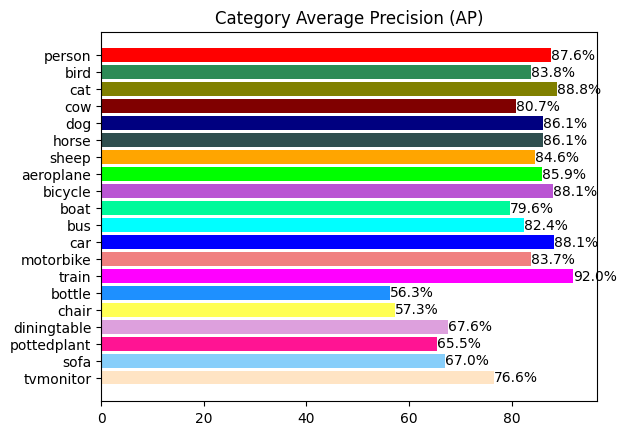

In [ ]:
model, test_loader = setup_evaluation()
mAP, average_precisions = evaluate_model(model, test_loader)
print(f'Mean Average Precision = {mAP:.1f}%')

# 绘制类别 AP
plot_class_ap(average_precisions)


## 5. 模型加载与推理

/tmp/ipykernel_488411/325265598.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model_weights = torch.load(TRAINED_MODEL_WEIGHTS)
/disk/liuweihong/.conda/envs/y

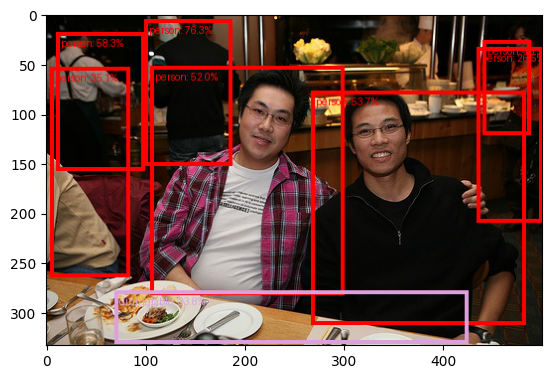

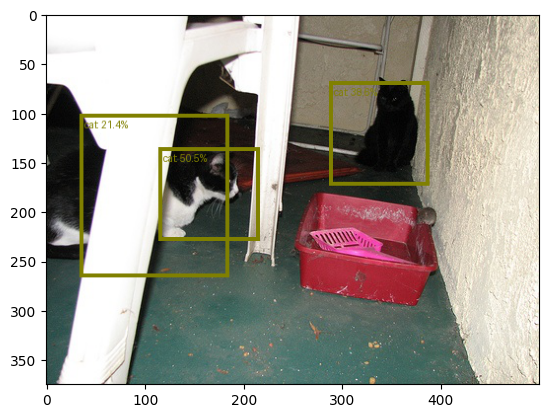

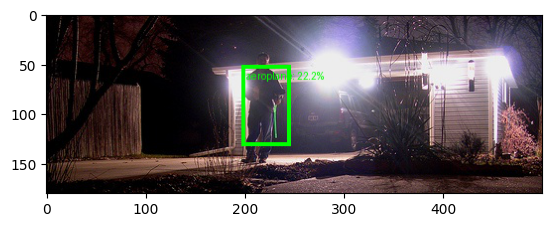

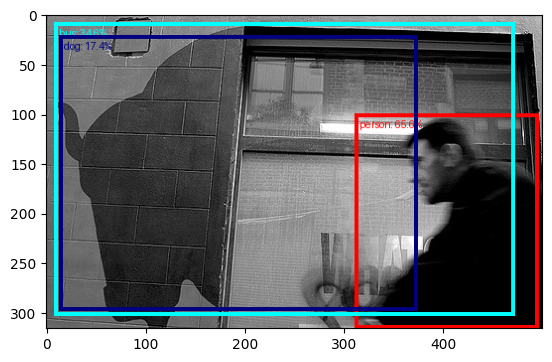

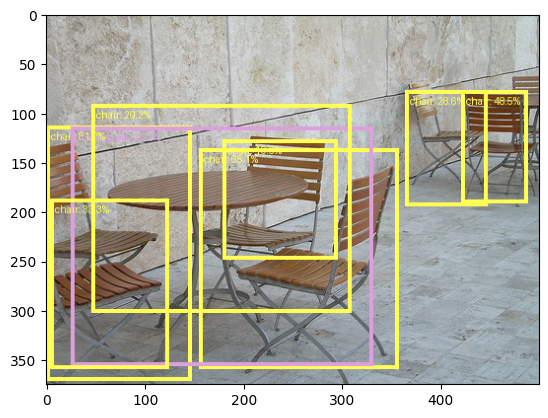

已显示 5 张图像，停止显示。


In [70]:
import torch
import torchvision.transforms.functional as fT
from torchvision.utils import draw_bounding_boxes
import PIL.Image as Image
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import os

# Model Hyperparameters
S = 7
B = 2
D = 448

# Trained Model Path
TRAINED_MODEL_WEIGHTS = "checkpoints/trained_model_weights.pt"

# VOC Dataset Directory
PASCAL_VOC_DIR_PATH = "data/voc/VOC_Detection"

# Save Image Path
ASSETS_DIR = "assets"

# Compute Device (use a GPU if available)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Postprocessing Hyperparameters
PROB_THRESHOLD = 0.15
NMS_THESHOLD = 0.6
CONF_MODE = 'objectness'

def annotate_img(img: Image.Image,
                 bboxes: torch.Tensor
                 ) -> Image:
    """
    给图像添加边界框和标签
    :param img: PIL图像
    :param bboxes: 真实框数据
    :return: 添加边界框后的PIL图像
    """
    img_tensor = fT.pil_to_tensor(img)
    bboxes_coords = bboxes[:, 2:]
    bboxes_class = bboxes[:, 0].long()
    objectness = bboxes[:, 1]
    text = [f'{VOC_Detection.index2label[bb_class_ind]}: {objectness[i] * 100:.1f}%' for i, bb_class_ind in
            enumerate(bboxes_class)]
    obj_clrs = [VOC_Detection.label_clrs[bb_class_ind] for bb_class_ind in bboxes_class]
    annotated_tensor = draw_bounding_boxes(img_tensor, bboxes_coords, text, width=4, font_size=20, colors=obj_clrs)
    annotated_img = fT.to_pil_image(annotated_tensor)
    return annotated_img


def update_plot(model: YOLOv1,
                img: Image.Image
                ) -> Image.Image:
    """
    给图像添加预测的边界框
    :param model: 训练好的YOLOv1模型
    :param img: 待检测的测试集图像
    :return: 绘制了边界框的图像
    """
    w, h = img.size
    x = fT.normalize(fT.to_tensor(fT.resize(img, (D, D))),
                     mean=[0.4549, 0.4341, 0.4010],
                     std=[0.2703, 0.2672, 0.2808]).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        y = model(x)
    bboxes_pred = postprocessing(y,
                                 prob_threshold=PROB_THRESHOLD,
                                 conf_mode=CONF_MODE,
                                 nms_threshold=NMS_THESHOLD)

    # 预测框坐标需要根据原图大小调整
    bboxes_pred[:, [2, 4]] *= w / D
    bboxes_pred[:, [3, 5]] *= h / D

    img = annotate_img(img, bboxes_pred)

    return img


def setup_evaluation() -> Tuple[YOLOv1, VOC_Detection]:
    """
    初始化YOLOv1模型和PASCAL VOC测试集，并加载训练好的模型权重。
    :return: YOLOv1模型和测试集
    """
    model = YOLOv1(S=S,
                   B=B,
                   C=VOC_Detection.C).to(DEVICE)
    trained_model_weights = torch.load(TRAINED_MODEL_WEIGHTS)
    model.load_state_dict(trained_model_weights)
    model.eval()

    test_dataset = VOC_Detection(root_dir=PASCAL_VOC_DIR_PATH,
                                 split='test')

    return model, test_dataset



def main():
    """
    显示图像并添加边界框。图像展示和保存通过参数控制。
    """
    model, test_dataset = setup_evaluation()


    max_show_count = 5  # 限制显示最多5张图像
    current_show_count = 0  # 当前已显示的图像计数
    save = False
    show = True
    i = 0
    while current_show_count < max_show_count:
        img = test_dataset[i][0]
        annot_img = update_plot(model, img)

        # 如果设置了保存，保存图像
        if save:
            path = os.path.join(ASSETS_DIR, f'annnot_img_{i}.jpg')
            annot_img.save(path)
            print(f"图像已保存: {path}")

        # 如果设置了显示，直接显示图像
        if show:
            plt.imshow(annot_img)  # 更新并显示图像
            plt.pause(0.1)  # 暂停，防止图像显示闪烁

        # 切换到下一张图像
        i = (i + 1) % len(test_dataset)  # 循环切换图像

        # 更新已显示图像计数
        current_show_count += 1

    print(f"已显示 {max_show_count} 张图像，停止显示。")



main()